In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
import warnings
warnings.simplefilter('ignore')
import sklearn as sk
from sklearn import decomposition, preprocessing
from sklearn import cluster, metrics
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy as sp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
df = pd.read_csv('df_analyse_p9', sep=',')

In [3]:
df.head()

Zone  Disponibilité alimentaire (Kcal/personne/jour)  \
0     Afghanistan                                             5.0   
1  Afrique du Sud                                           143.0   
2         Albanie                                            85.0   
3         Algérie                                            22.0   
4       Allemagne                                            71.0   

   Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                               1.53        
1                                              35.69        
2                                              16.36        
3                                               6.38        
4                                              19.47        

   Disponibilité intérieure (Milliers T)  Nourriture (Milliers T)  \
0                                   57.0                     55.0   
1                                 2118.0                   2035.0   
2                                   47.0                     47.0   
3                                  277.0                    264.0   
4                                 1739.0                   1609.0   

   Production (Milliers T)  Population  Stabilité politique (indice)  \
0                     28.0    36296113                         -2.80   
1                   1667.0    57009756                         -0.28   
2                     13.0     2884169                          0.38   
3                    275.0    41389189                         -0.92   
4                   1514.0    82658409                          0.59   

   PIB (Mrd $)  Import - Prix - (M $)  Import - Qt - (M $)  \
0    18.896352                 3657.9               4033.9   
1   380.851444                46569.8              39137.6   
2    13.019730                 2299.6               1963.0   
3   170.096987                    1.3                  1.1   
4  3690.849153               180713.1             152983.8   

   Distance à la France (km)  Indice Import (Qt, 2015)  \
0                  5590.3810                      72.0   
1                  9353.5520                     128.0   
2                  1603.5340                      85.0   
3                  1340.3900                     129.0   
4                   439.8984                     112.0   

   Indice Import (Valeur, 2015)  Indice Import (Valeur unitaire, 2015)  \
0                          57.0                                   80.0   
1                         139.0                                  106.0   
2                          61.0                                   72.0   
3                         147.0                                   55.0   
4                         107.0                                   95.0   

    PIB_hab ($)  
0    520.616409  
1   6680.460869  
2   4514.204910  
3   4109.696066  
4  44651.829108

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Zone                                                    163 non-null    object 
 1   Disponibilité alimentaire (Kcal/personne/jour)          163 non-null    float64
 2   Disponibilité alimentaire en quantité (kg/personne/an)  163 non-null    float64
 3   Disponibilité intérieure (Milliers T)                   163 non-null    float64
 4   Nourriture (Milliers T)                                 163 non-null    float64
 5   Production (Milliers T)                                 163 non-null    float64
 6   Population                                              163 non-null    int64  
 7   Stabilité politique (indice)                            163 non-null    float64
 8   PIB (Mrd $)                             

<h1 style="font-size:22px;color:red"> Préparation des données de la classification ascendante hiérarchique </h1>

<h2 style="font-size:19px;color:blue"> Test de corrélation des variables </h2>

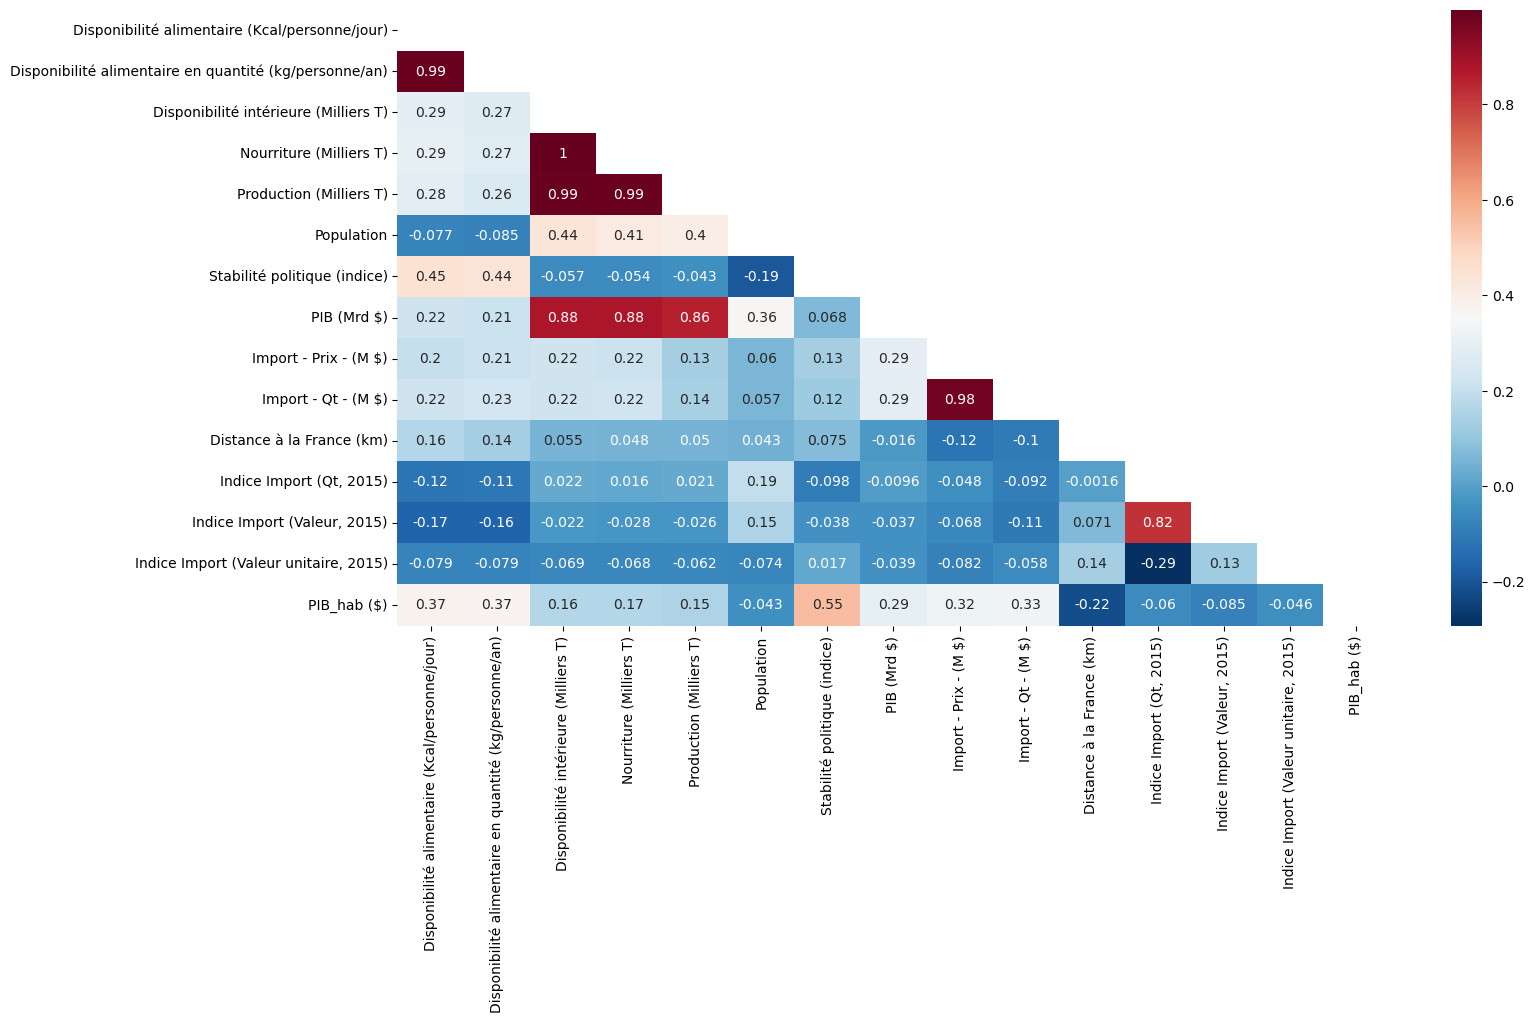

In [5]:
matrix = df.corr()

# Masque pour éviter les doublons de corrélations
mask = np.triu(np.ones_like(matrix, dtype=bool))

palette_matrix = sns.color_palette("RdBu_r", as_cmap=True)

# Créer la carte de chaleur avec la palette personnalisée
plt.figure(figsize=(16, 8))
sns.heatmap(matrix, mask=mask, annot=True, cmap=palette_matrix)
plt.show()

##### La matrice de corrélation entre les variables nous permet d'explorer les relations mutuelles et les potentiels clusters au sein des données. Pour garantir la pertinence et la non-redondance des informations, nous allons mettre en évidence les variables présentant une corrélation supérieure à 0.8. Pour chaque paire, une variable sera potentiellement exclues du dataframe.

- Disponibilité alimentaire en quantité (kg/personne/an) et Disponibilité alimentaire (Kcal/personne/an)
- Nourriture et Disponibilité intérieure
- Production et Nourriture
- Importations (Qt) et Importations (Prix)
- Indice d'Importations (Valeur, 2015) et Indice d'Importations (Qt, 2015)
- PIB et Dispo intérieure, Nourriture, Production

##### A partir de ces paires, les variables à exclure seraient potentiellement : 
- Dispo alimentaire (kcal/personne/an)
- Dispo intérieure
- Production
- Importation (Qt)
- Indice Import (Qt)
- PIB

<h2 style="font-size:19px;color:blue"> Clustering des données par la méthode "Ward" </h2>

##### Permet de mieux comprendre la distribution et répartition des variables dans un ensemble de données.

In [6]:
df = df.set_index('Zone')
df.reset_index().head()

Zone  Disponibilité alimentaire (Kcal/personne/jour)  \
0     Afghanistan                                             5.0   
1  Afrique du Sud                                           143.0   
2         Albanie                                            85.0   
3         Algérie                                            22.0   
4       Allemagne                                            71.0   

   Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                               1.53        
1                                              35.69        
2                                              16.36        
3                                               6.38        
4                                              19.47        

   Disponibilité intérieure (Milliers T)  Nourriture (Milliers T)  \
0                                   57.0                     55.0   
1                                 2118.0                   2035.0   
2                                   47.0                     47.0   
3                                  277.0                    264.0   
4                                 1739.0                   1609.0   

   Production (Milliers T)  Population  Stabilité politique (indice)  \
0                     28.0    36296113                         -2.80   
1                   1667.0    57009756                         -0.28   
2                     13.0     2884169                          0.38   
3                    275.0    41389189                         -0.92   
4                   1514.0    82658409                          0.59   

   PIB (Mrd $)  Import - Prix - (M $)  Import - Qt - (M $)  \
0    18.896352                 3657.9               4033.9   
1   380.851444                46569.8              39137.6   
2    13.019730                 2299.6               1963.0   
3   170.096987                    1.3                  1.1   
4  3690.849153               180713.1             152983.8   

   Distance à la France (km)  Indice Import (Qt, 2015)  \
0                  5590.3810                      72.0   
1                  9353.5520                     128.0   
2                  1603.5340                      85.0   
3                  1340.3900                     129.0   
4                   439.8984                     112.0   

   Indice Import (Valeur, 2015)  Indice Import (Valeur unitaire, 2015)  \
0                          57.0                                   80.0   
1                         139.0                                  106.0   
2                          61.0                                   72.0   
3                         147.0                                   55.0   
4                         107.0                                   95.0   

    PIB_hab ($)  
0    520.616409  
1   6680.460869  
2   4514.204910  
3   4109.696066  
4  44651.829108

In [7]:
# Préparation des données pour le clustering
X = df.values
names = df.index

# Centrage et Réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique (Calcul des distances)
Z = linkage(X_scaled, 'ward')

- Ce code a pour effet de préparer les données, de les centrer et réduire, puis exécute une méthode de clustering hiérarchique avec la méthode "Ward". Cette méthode calcule les distances entre les clusters, en cherchant à minimiser la variance totale des distances entre les clusters.
- Ce type de classification hiérarchique est utilisé pour identifier des structures similaires dans les données, et regrouper les observations similaires entres elles. Le résultat du clustering est stocké dans la matrice "Z".

### Analyse de la densité des variables

<AxesSubplot:ylabel='Density'>

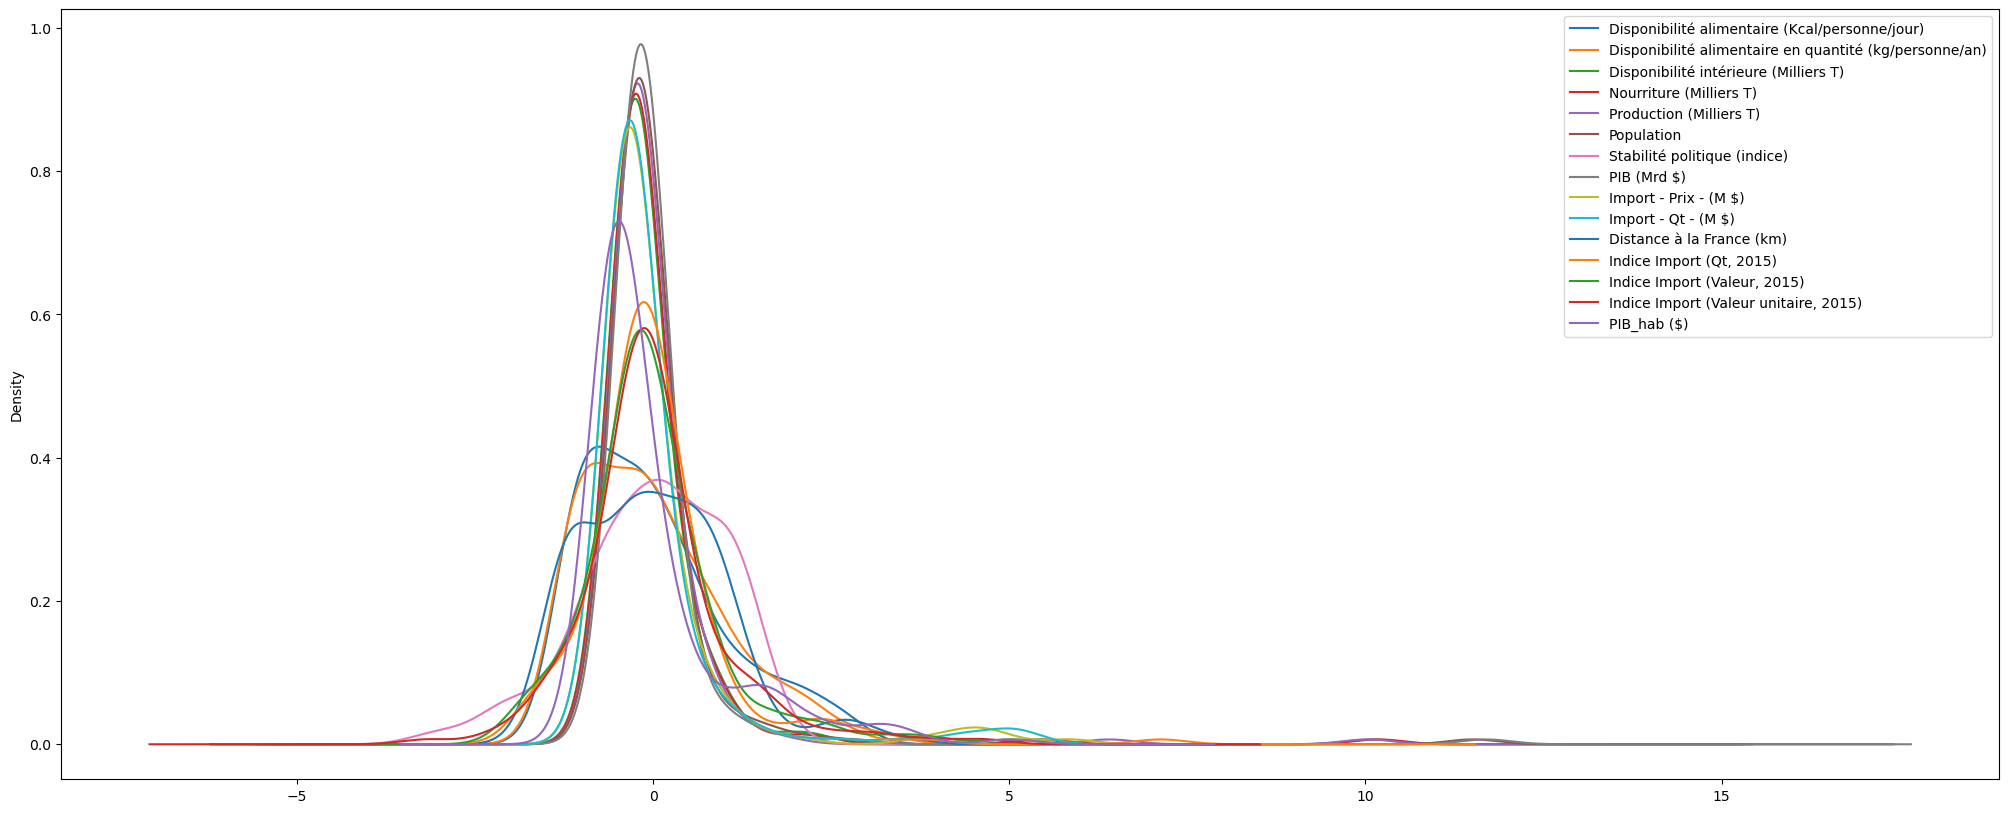

In [8]:
# Courbes de densités
pd.DataFrame(X_scaled,columns=df.columns).plot(kind='density',sharex=True,figsize=(25,10),layout=(10,1))

- Les données étants centrées et réduites, ce graphique affiche les courbes de densités de chacune des variables.
- Ces courbes montrent comment les valeurs sont distribuées pour chaque variable, et aide à visualiser les différences de distribution. 
##### La distribution de nos variables semblent êtres divisés en 3 groupes :
- Un premier groupe (pic de densité = 0.4) représente des variables dont les valeurs sont réparties de manière plus uniforme sur toute la gamme des valeurs possibles. 
- Un second groupe (pic de densité élevé, +/- 0.9) représente des observations dans une plage de valeur relativement restreinte.
- Un troisième groupe, qui représente des variables dont les valeurs se situent entre le premier et le second groupe. 

<h2 style="font-size:19px;color:blue"> Estimation du nombre optimal de clusters </h2>

### La méthode du Coude

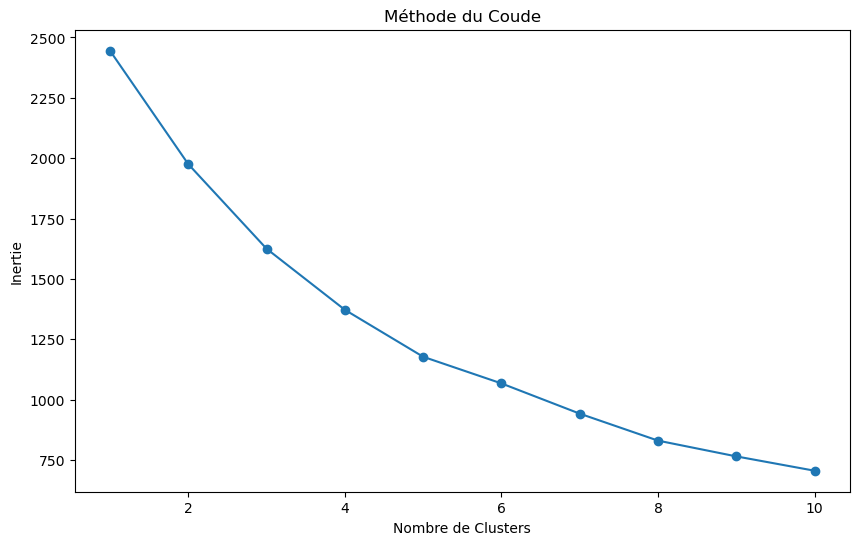

In [12]:
# Calcul des inerties pour différents nombres de clusters
inertie = []
for i in range(1, 11):  # Essayer de 1 à 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled)
    inertie.append(kmeans.inertia_)

# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertie, marker='o')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie')
plt.show()

- La méthode du "coude" permet une première approche afin de déterminer le nombre optimal de clusters à afficher. Le ralentissement de la pente du coude suggère un nombre optimal de cluster.
- On observe un ralentissement de l'inertie à 5 et 7 clusters, qui pourrait s'apparenter au nombre optimal de cluster

### La méthode Silouhette

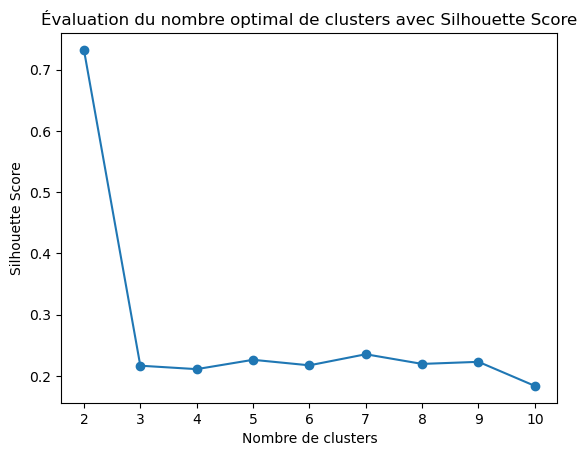

In [13]:
# Liste pour stocker nos coefficients
silhouettes = []

# Boucle itérative de 2 à 10 (clusters) pour tester les possibilités
for k in range(2, 11):
    # Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k, init='k-means++')
    cls.fit(X_scaled)

    # Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)

# Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.plot(range(2, 11), silhouettes, marker='o')
plt.title('Évaluation du nombre optimal de clusters avec Silhouette Score')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

- La méthode de la silouhette permet d'évaluer le nombre ainsi que la qualité de la séparation des clusters.
- Notre jeu de données suggère une nette séparation avec 2 clusters. La qualité de cette séparation baisse drastiquement à partir de 3 clusters.
- Cette silouhette suggère un manque d'efficacité de nos variables à séparer distinctement notre jeu de données en divers clusters. Nous décidons d'effectuer de nouveaux tests en supprimant diverses variables, et en conservant uniquement celles qui nous semblent le plus importantes.

<h2 style="font-size:19px;color:blue"> Création d'un second dataframe pour affiner l'étude </h2>

- Nous nous référons à la matrice de corrélation précédente (section 1.1), et supprimons les variables qui semblent très corrélées entres elles, afin d'éviter la redondance d'informations, et contribuer à affiner l'analyse. 

In [14]:
df.columns

Index(['Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité intérieure (Milliers T)', 'Nourriture (Milliers T)',
       'Production (Milliers T)', 'Population', 'Stabilité politique (indice)',
       'PIB (Mrd $)', 'Import - Prix - (M $)', 'Import - Qt - (M $)',
       'Distance à la France (km)', 'Indice Import (Qt, 2015)',
       'Indice Import (Valeur, 2015)', 'Indice Import (Valeur unitaire, 2015)',
       'PIB_hab ($)'],
      dtype='object')

In [15]:
df2 = df[[#'Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
    #'Disponibilité intérieure (Milliers T)',
    'Nourriture (Milliers T)',
    #'Production (Milliers T)', 
    'Population', 
    'Stabilité politique (indice)',
    'PIB (Mrd $)', 
    'Import - Prix - (M $)', 
    #'Import - Qt - (M $)',
    'Distance à la France (km)',
    #'Indice Import (Qt, 2015)', 
    'Indice Import (Valeur, 2015)',
    #'Indice Import (Valeur unitaire, 2015)', 
    'PIB_hab ($)'
]]
df2

Disponibilité alimentaire en quantité (kg/personne/an)  \
Zone                                                                            
Afghanistan                                                         1.53        
Afrique du Sud                                                     35.69        
Albanie                                                            16.36        
Algérie                                                             6.38        
Allemagne                                                          19.47        
...                                                                  ...        
Émirats arabes unis                                                43.47        
Équateur                                                           19.31        
États-Unis d'Amérique                                              55.68        
Éthiopie                                                            0.13        
Îles Salomon                                                        4.45        

                       Nourriture (Milliers T)  Population  \
Zone                                                         
Afghanistan                               55.0    36296113   
Afrique du Sud                          2035.0    57009756   
Albanie                                   47.0     2884169   
Algérie                                  264.0    41389189   
Allemagne                               1609.0    82658409   
...                                        ...         ...   
Émirats arabes unis                      412.0     9487203   
Équateur                                 324.0    16785361   
États-Unis d'Amérique                  18100.0   325084756   
Éthiopie                                  14.0   106399924   
Îles Salomon                               3.0      636039   

                       Stabilité politique (indice)   PIB (Mrd $)  \
Zone                                                                
Afghanistan                                   -2.80     18.896352   
Afrique du Sud                                -0.28    380.851444   
Albanie                                        0.38     13.019730   
Algérie                                       -0.92    170.096987   
Allemagne                                      0.59   3690.849153   
...                                             ...           ...   
Émirats arabes unis                            0.62    385.605507   
Équateur                                      -0.07    104.295862   
États-Unis d'Amérique                          0.29  19477.337000   
Éthiopie                                      -1.68     76.794686   
Îles Salomon                                   0.20      1.469790   

                       Import - Prix - (M $)  Distance à la France (km)  \
Zone                                                                      
Afghanistan                           3657.9                  5590.3810   
Afrique du Sud                       46569.8                  9353.5520   
Albanie                               2299.6                  1603.5340   
Algérie                                  1.3                  1340.3900   
Allemagne                           180713.1                   439.8984   
...                                      ...                        ...   
Émirats arabes unis                  70147.7                  5249.5350   
Équateur                                 9.4                  9367.0980   
États-Unis d'Amérique                24640.5                  5838.1570   
Éthiopie                                83.6                  5582.5020   
Îles Salomon                           960.0                 15178.2000   

                       Indice Import (Valeur, 2015)   PIB_hab ($)  
Zone                                                               
Afghanistan                                    57.0    520.616409  
Afrique du Sud                                139.0   6680.460869  
Albanie         

- Après suppression de 5 variables, nous avons désormais un jeu de 10 variables distinctes, et non corrélées les unes aux autres

In [16]:
# Préparation du df2 pour le clustering
X2 = df2.values
names2 = df2.index

# Centrage et Réduction
std_scale2 = StandardScaler().fit(X2)
X_scaled2 = std_scale2.transform(X2)

# Clustering hiérarchique
Z2 = linkage(X_scaled2, 'ward')

<h2 style="font-size:19px;color:blue"> Nouvelle estimation du nombre de clusters (df2) </h2>

### La méthode du Coude

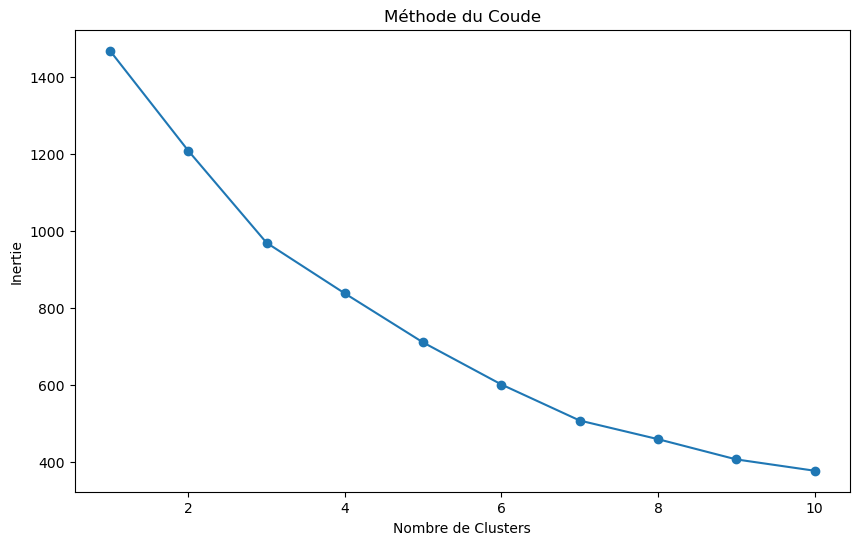

In [17]:
# Calcul des inerties pour différents nombres de clusters
inertie = []
for i in range(1, 11):  # Essayer de 1 à 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled2)
    inertie.append(kmeans.inertia_)

# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertie, marker='o')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie')
plt.show()

- L'Inertie est une mesure de la variance expliquée pour chaque composante principale. La baisse de l'inertie à mesure que le nombre de clusters augmente détermine le point ou l'ajout d'une nouvelle composante (cluster) apporte un faible gain. 
- On observe un ralentissement du coude à 3 puis 6 clusters.

### La méthode de la Silouhette

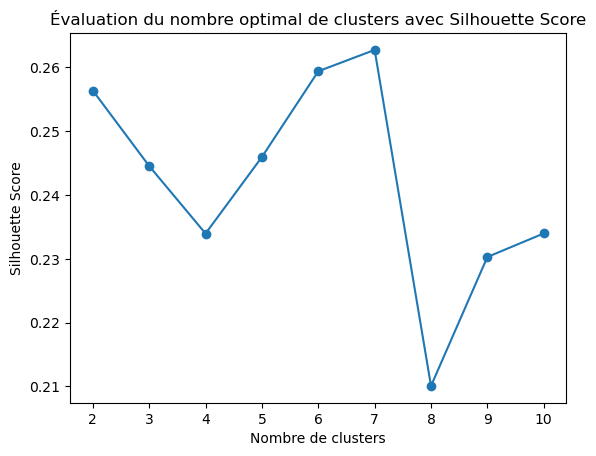

In [18]:
# Liste pour stocker nos coefficients
silhouettes = []

# Boucle itérative de 2 à 10 (clusters) pour tester les possibilités
for k in range(2, 11):
    # Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k, init='k-means++')
    cls.fit(X_scaled2)

    # Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled2, cls.labels_)
    silhouettes.append(silh)

# Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.plot(range(2, 11), silhouettes, marker='o')
plt.title('Évaluation du nombre optimal de clusters avec Silhouette Score')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

- Avec ce nouveau jeu de données, et malgré un faible score de la silouhette, on déduis que la meilleure séparation des clusters interviendrait à 6 ou 7 clusters. 
- En combinant la méthode de "Coude" et "Silouhette", nous optons pour la création de 6 clusters distincts.

<h1 style="font-size:22px;color:red"> Classification ascendante hiérarchique (Dendogramme de visualisation) </h1>

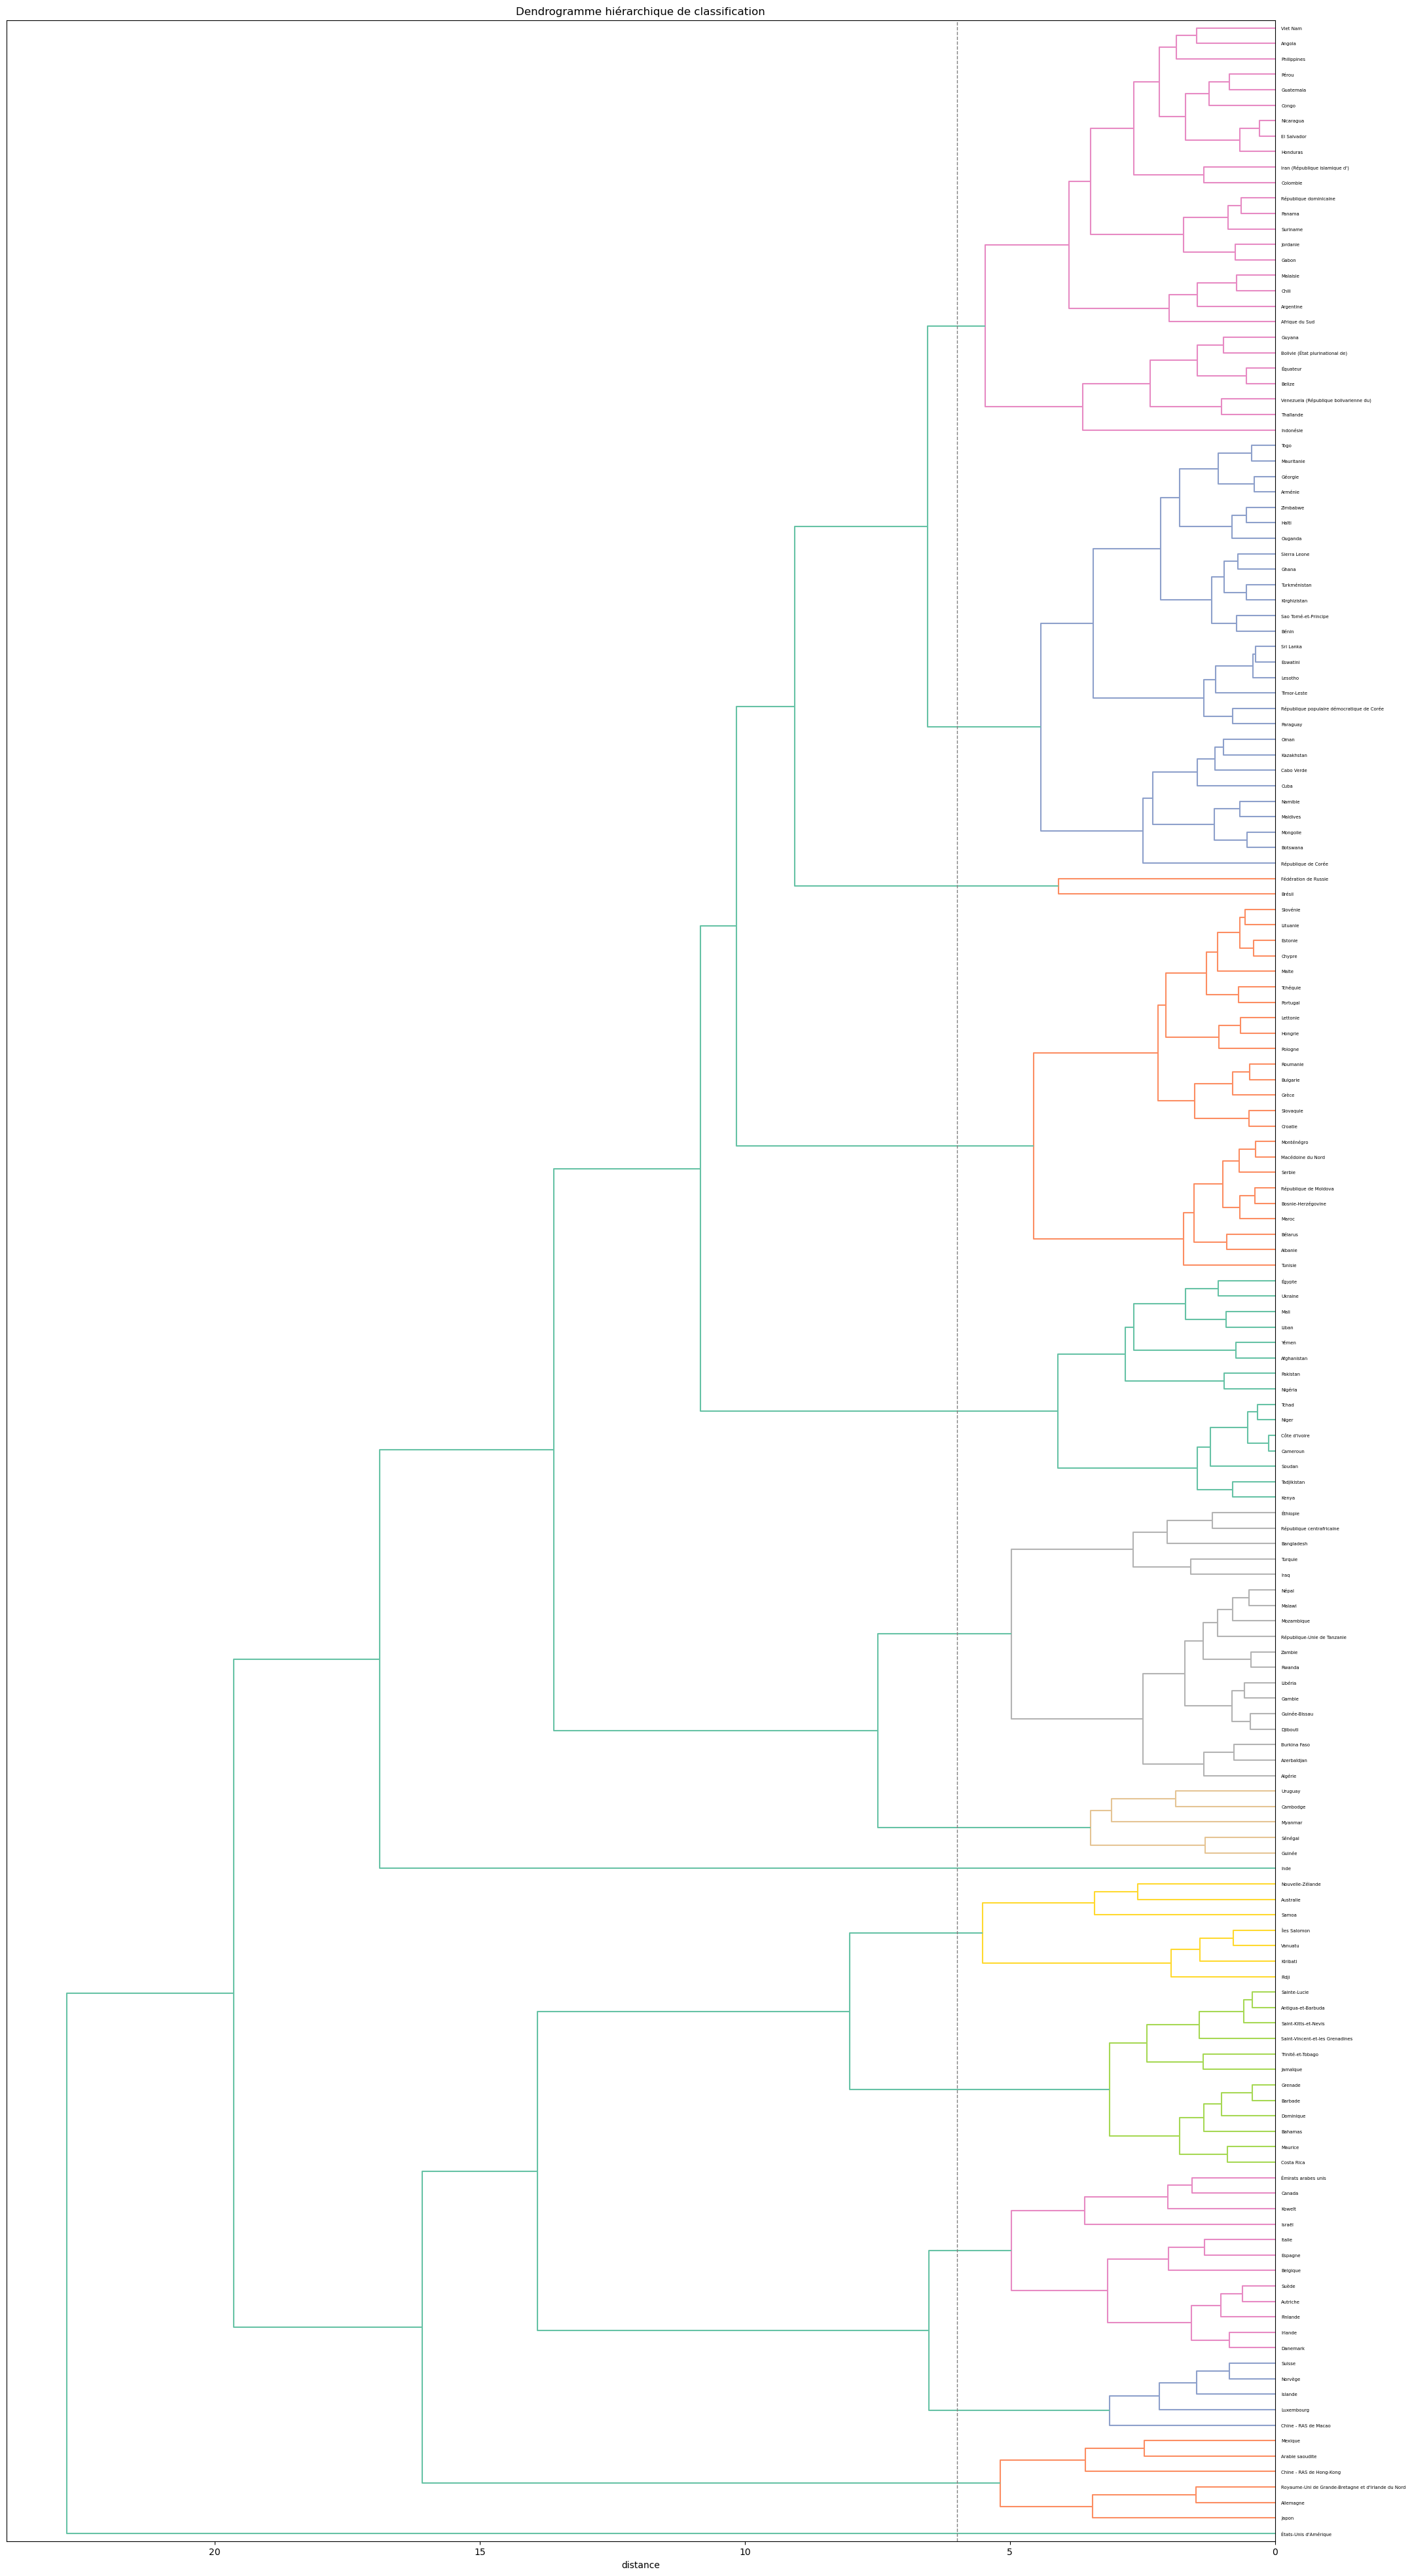

In [19]:
plt.figure(figsize=(25,50))
sns.set_palette('Set2')
dendrogram(Z2,
        labels = names2,
        orientation = "left", color_threshold=6)
plt.axvline(x=6, c='grey', lw=1, linestyle='dashed')

plt.title('Dendrogramme hiérarchique de classification')
plt.xlabel('distance')
plt.show()

- Ce premier dendogramme de visualisation représente la manière dont les pays sont regroupés en différents "clusters" et permet de voir visuellement quels pays sont similaires les uns des autres, et quelle distance les séparent. 
- Plus la distance est faible, plus les pays sont similaires les uns des autres. A l'inverse, plus la distance est grande, plus ils sont différents et peuvent être divisés en sous-groupe.
- La ligne verticale permet de scinder nos pays en 6 groupes distincts. 

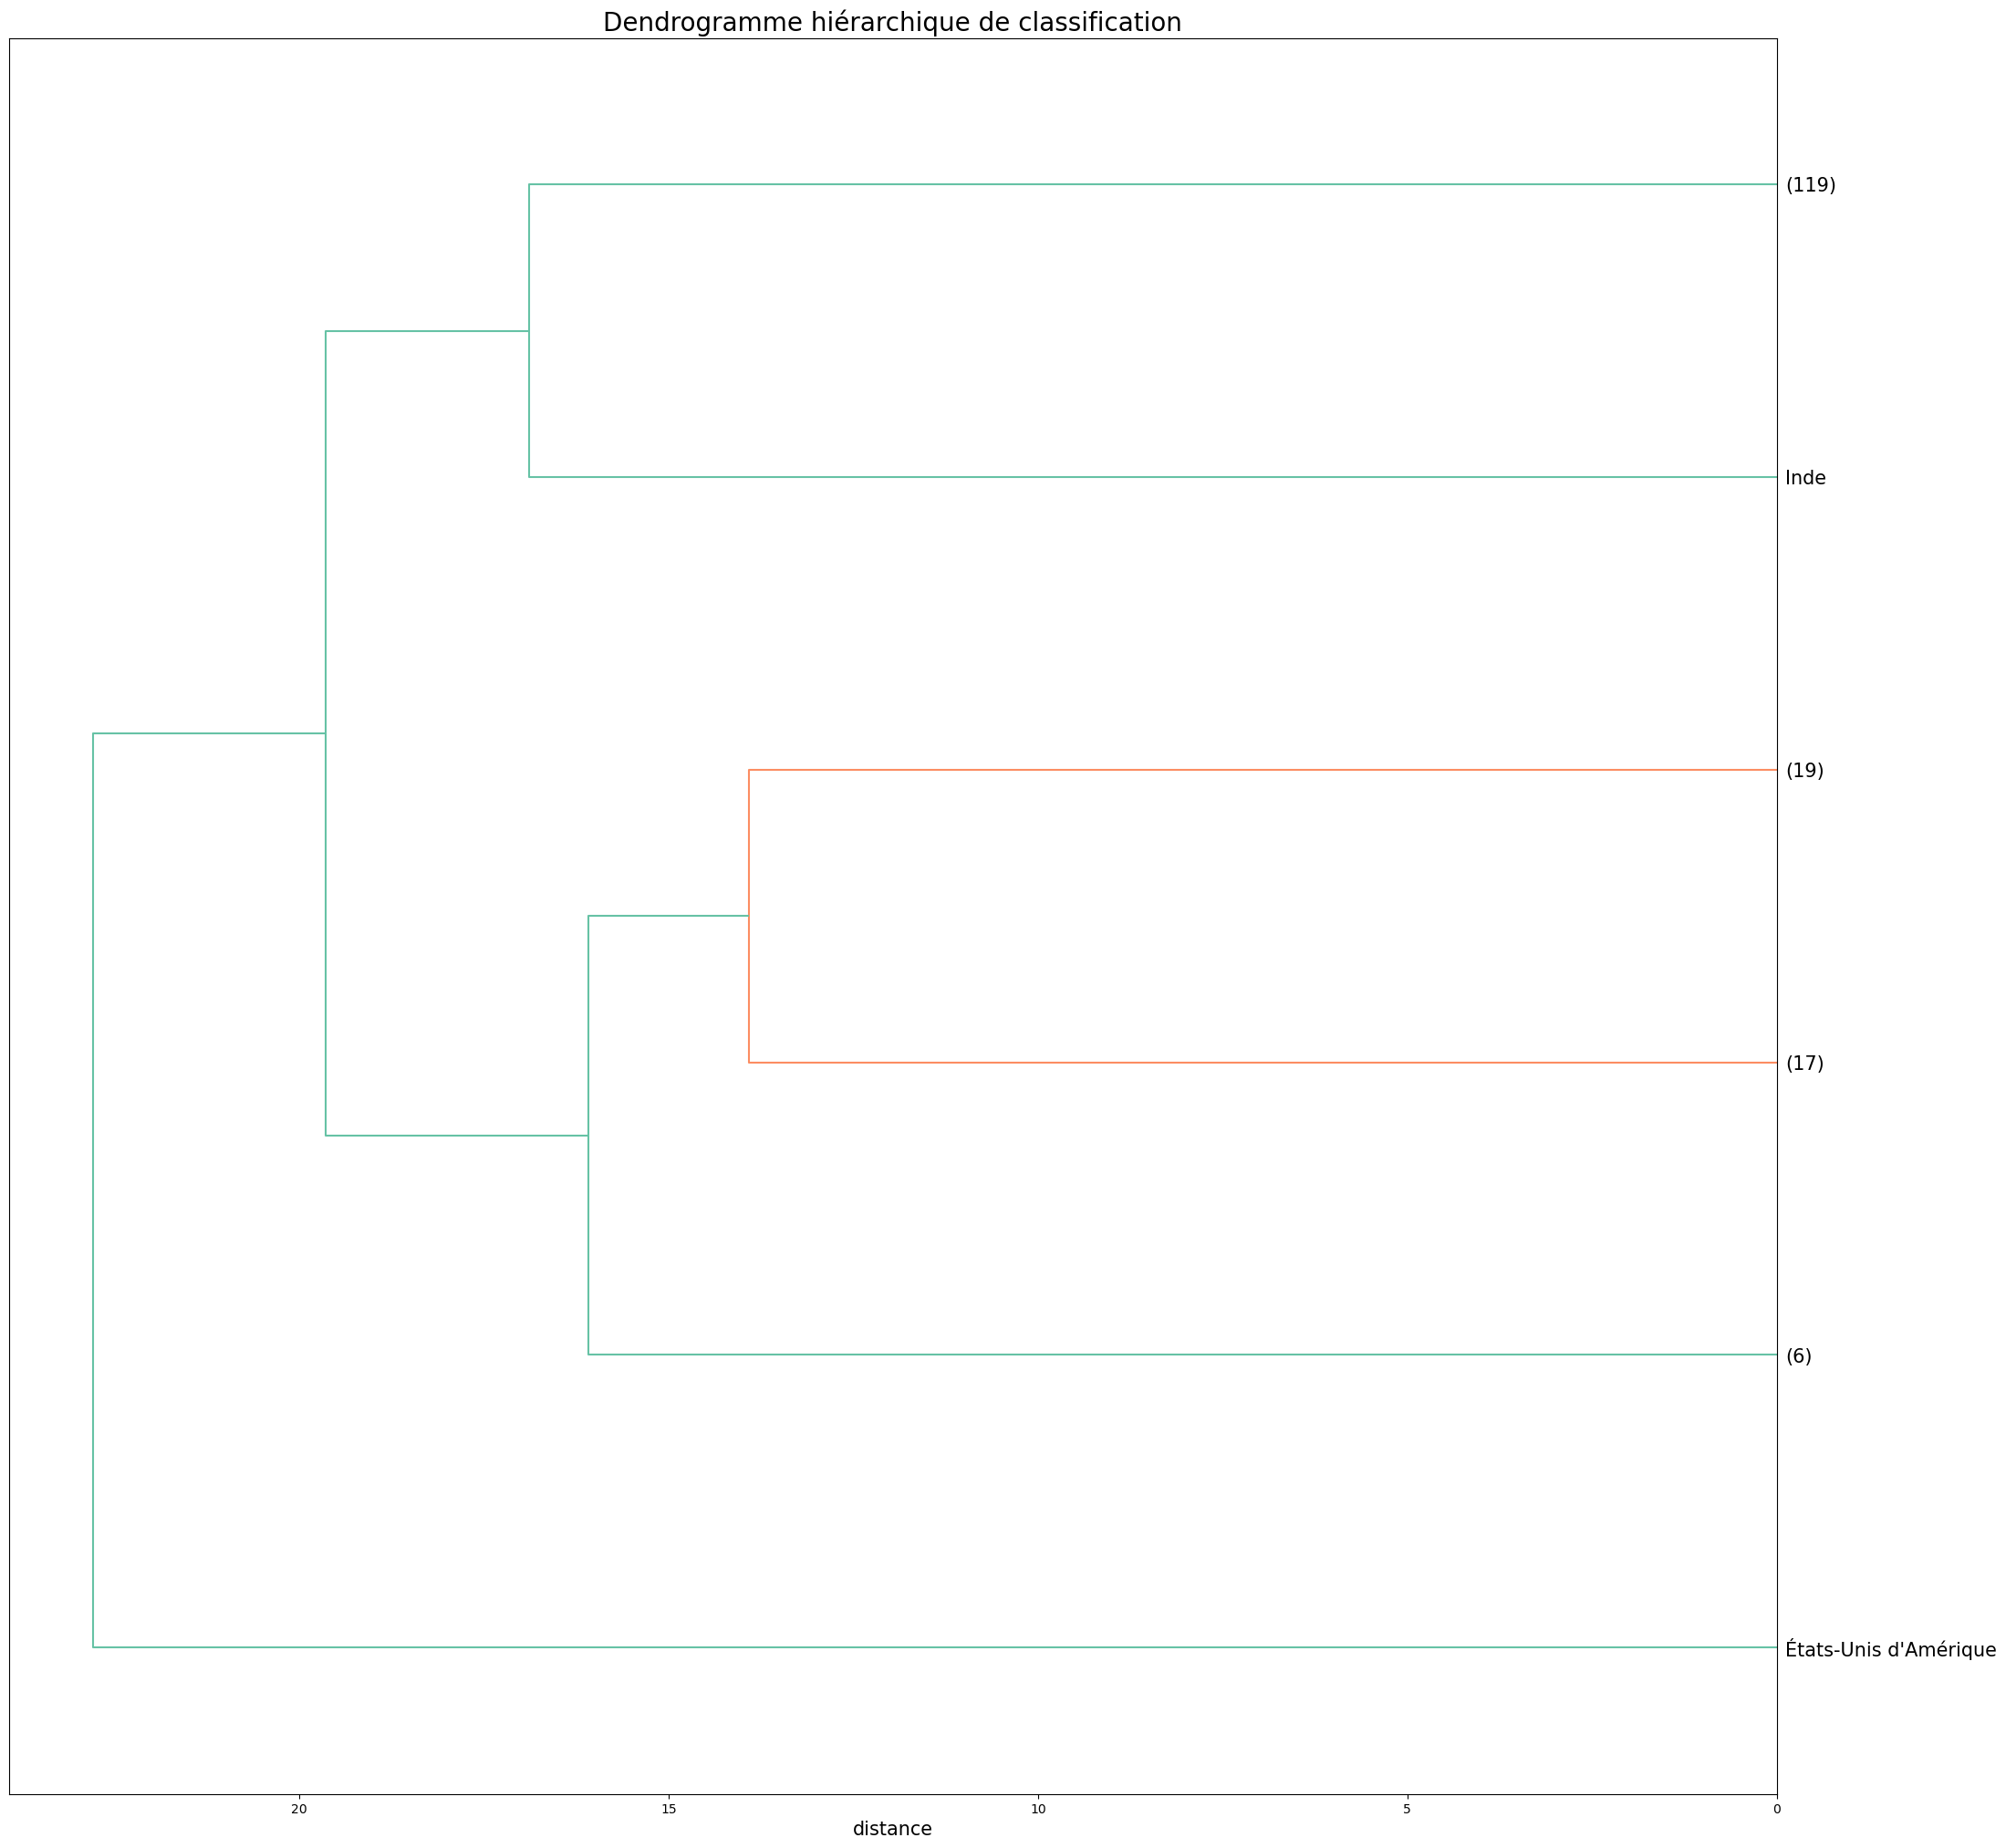

In [20]:
fig = plt.figure(figsize=(25,25))
plt.title('Dendrogramme hiérarchique de classification', fontsize=20)
plt.xlabel('distance', fontsize=15)

dendrogram(Z2, labels = df2.index, p=6, truncate_mode='lastp', leaf_font_size=15, orientation='left')
plt.show()

- Le dendrogramme suivant est une version simplifiée du précédent, affichant uniquement les groupes finaux du regroupement hiérarchique. Chaque groupe est identifié par un nombre entre parenthèses, représentant le nombre de pays inclus dans le même cluster.
- Parmi les 6 clusters que nous avons formés, nous observons la création d'un groupe considérable de 119 pays, ainsi que trois autres clusters de taille moyenne (19, 17 et 6 pays). De plus, deux clusters isolés se distinguent, chacun étant constitué d'un seul pays : l'Inde et les États-Unis.

<h2 style="font-size:19px;color:blue"> Création d'un dataframe avec les clusters associés </h2>

In [21]:
cluster2 = fcluster(Z2, t=6, criterion='maxclust')
df2_cluster = pd.DataFrame({'Zone' : df2.index.tolist(),'cluster' : cluster2})
df2_cluster = df2_cluster.sort_values(['cluster', 'Zone'])
df2_cluster

Zone  cluster
4                   Allemagne        1
7             Arabie saoudite        1
31   Chine - RAS de Hong-Kong        1
72                      Japon        1
94                    Mexique        1
..                        ...      ...
157                    Égypte        4
159                  Équateur        4
161                  Éthiopie        4
63                       Inde        5
160     États-Unis d'Amérique        6

[163 rows x 2 columns]

<h2 style="font-size:19px;color:blue"> Standardisation des données </h2>

In [22]:
ss = preprocessing.StandardScaler()
df2_stand = pd.DataFrame(ss.fit_transform(df2),columns = df2.columns, index=df2.index) 
# Standardisation du données df2 dans un df "df2_stand"

df2_stand_clust = pd.merge(df2_cluster, df2_stand , on='Zone')
df2_stand_clust
# Création d'un df "df2_stand_clust" qui joint les clusters au dataframe standardisé

Zone  cluster  \
0                   Allemagne        1   
1             Arabie saoudite        1   
2    Chine - RAS de Hong-Kong        1   
3                       Japon        1   
4                     Mexique        1   
..                        ...      ...   
158                    Égypte        4   
159                  Équateur        4   
160                  Éthiopie        4   
161                      Inde        5   
162     États-Unis d'Amérique        6   

     Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                            -0.043535        
1                                             1.463239        
2                                             2.103412        
3                                            -0.104714        
4                                             0.779546        
..                                                 ...        
158                                          -0.454129        
159                                          -0.053626        
160                                          -1.263334        
161                                          -1.131515        
162                                           2.240277        

     Nourriture (Milliers T)  Population  Stabilité politique (indice)  \
0                   0.608288    0.416859                      0.736841   
1                   0.507279   -0.020674                     -0.619220   
2                  -0.098772   -0.248413                      1.001439   
3                   1.043669    0.812782                      1.310135   
4                   2.029954    0.788720                     -0.795618   
..                       ...         ...                           ...   
158                 0.399885    0.538557                     -1.479161   
159                -0.137666   -0.164724                      0.009199   
160                -0.317624    0.626469                     -1.765808   
161                 1.395458   11.506052                     -0.751519   
162                10.181458    2.557204                      0.406095   

     PIB (Mrd $)  Import - Prix - (M $)  Distance à la France (km)  \
0       2.020497               5.839402                  -1.450679   
1       0.181260               4.546525                  -0.323964   
2      -0.031511               4.243529                   0.985578   
3       2.780135               4.569098                   1.008393   
4       0.469390               3.791932                   0.870999   
..           ...                    ...                        ...   
158    -0.121036               0.121701                  -0.715712   
159    -0.176686              -0.425335                   0.913446   
160    -0.193534              -0.422762                  -0.088801   
161     1.367129              -0.424364                   0.179127   
162    11.691569               0.428590                  -0.021098   

     Indice Import (Valeur, 2015)  PIB_hab ($)  
0                       -0.073334     1.594880  
1                       -0.708707     0.363188  
2                       -0.182255     1.701122  
3                       -0.091487     1.286075  
4                       -0.273022    -0.231481  
..                            ...          ...  
158                     -0.291176    -0.606654  
159                     -1.725304    -0.390254  
160                      0.906956    -0.673873  
161                      2.177703    -0.609904  
162                     -0.400097     2.383122  

[163 rows x 11 columns]

<h2 style="font-size:19px;color:blue"> Heatmap de corrélation </h2>

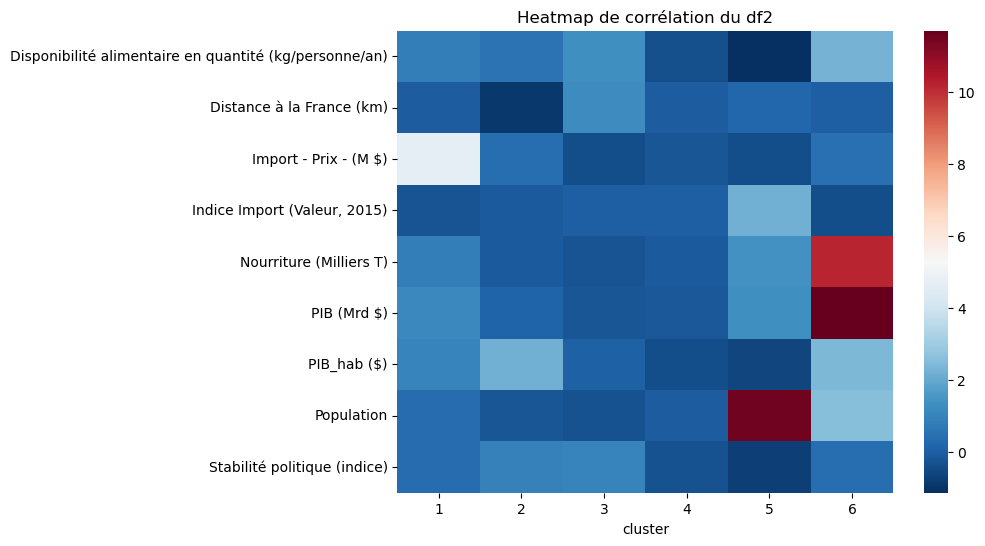

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(df2_stand_clust.pivot_table(columns="cluster", aggfunc='mean', fill_value=0), cmap="RdBu_r")
plt.title("Heatmap de corrélation du df2")
plt.show()

- Cluster 1 : Représente des pays aux Importations élevées
- Cluster 2 : Représente des pays très proche de la France
- Cluster 3 : Légère sensibilité à la disponibilité alimentaire, la distance par rapport à la france.
- Cluster 4 : Peu de sensibilité pour aucune des variables.
- Cluster 5 : Très forte sensibilité à la population, légère sensibilité à l'indice d'importation (en valeur, par rapport à 2015), la nourriture ainsi que le PIB 
- Cluster 6 : Très forte sensibilité à la Nourriture ainsi qu'au PIB, légère sensibilité à la population, au PIB par habitant ainsi qu'à la disponibilité alimentaire

<h2 style="font-size:19px;color:blue"> Analyse des clusters individuels </h2>

In [24]:
df2_cluster_1 = df2_stand_clust[df2_stand_clust['cluster'] == 1]
number_countries_1 = len(df2_cluster_1)
print(f"Il y a {number_countries_1} pays dans le cluster 1")

df2_cluster_2 = df2_stand_clust[df2_stand_clust['cluster'] == 2]
number_countries_2 = len(df2_cluster_2)
print(f"Il y a {number_countries_2} pays dans le cluster 2")

df2_cluster_3 = df2_stand_clust[df2_stand_clust['cluster'] == 3]
number_countries_3 = len(df2_cluster_3)
print(f"Il y a {number_countries_3} pays dans le cluster 3")

df2_cluster_4 = df2_stand_clust[df2_stand_clust['cluster'] == 4]
number_countries_4 = len(df2_cluster_4)
print(f"Il y a {number_countries_4} pays dans le cluster 4")

df2_cluster_5 = df2_stand_clust[df2_stand_clust['cluster'] == 5]
number_countries_5 = len(df2_cluster_5)
print(f"Il y a {number_countries_5} pays dans le cluster 5")

df2_cluster_6 = df2_stand_clust[df2_stand_clust['cluster'] == 6]
number_countries_6 = len(df2_cluster_6)
print(f"Il y a {number_countries_6} pays dans le cluster 6")

Il y a 6 pays dans le cluster 1
Il y a 17 pays dans le cluster 2
Il y a 19 pays dans le cluster 3
Il y a 119 pays dans le cluster 4
Il y a 1 pays dans le cluster 5
Il y a 1 pays dans le cluster 6


In [25]:
df2_clust5_6 = df2_stand_clust[df2_stand_clust['cluster'].isin([5, 6])]
df2_clust5_6

Zone  cluster  \
161                   Inde        5   
162  États-Unis d'Amérique        6   

     Disponibilité alimentaire en quantité (kg/personne/an)  \
161                                          -1.131515        
162                                           2.240277        

     Nourriture (Milliers T)  Population  Stabilité politique (indice)  \
161                 1.395458   11.506052                     -0.751519   
162                10.181458    2.557204                      0.406095   

     PIB (Mrd $)  Import - Prix - (M $)  Distance à la France (km)  \
161     1.367129              -0.424364                   0.179127   
162    11.691569               0.428590                  -0.021098   

     Indice Import (Valeur, 2015)  PIB_hab ($)  
161                      2.177703    -0.609904  
162                     -0.400097     2.383122

- A la suite de ce premier clustering, nous remarquons que les clusters individuels (Inde et USA) ont une influence trop grande sur le reste des clusters, et nous décidons de les supprimer du dataframe. 

- Malgré sa taille et sa population, l'Inde n'est pas grande importatrice de viandes de volaille, et possède une stabilité politique relativement faible.

- Concernant les USA, le choix de l'écarter de nos données est plus complexe. La création de son cluster individuel est lié à la variable "Nourriture", dont la valeur d'origine était extrêmement élevée. Les USA sont un pays interessant à qui exporter sa production car possède des caractéristiques à privilégier : Forte propension à consommer de la viande de volaille, stabilité politique du pays, propension à importer, fort PIB. Néanmoins, nous pouvons nous appuyer sur diverses raisons afin d'écarter ce pays : Continent éloigné de la France, incluant des coûts de transports élevés, pays producteur, pouvant assouvir la consommation de son propre pays.

### Suppression de l'Inde, de l'USA

In [26]:
Inde_USA = ["Inde", "États-Unis d'Amérique"]
df2 = df2[~df2.index.isin(Inde_USA)]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161 entries, Afghanistan to Îles Salomon
Data columns (total 9 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Disponibilité alimentaire en quantité (kg/personne/an)  161 non-null    float64
 1   Nourriture (Milliers T)                                 161 non-null    float64
 2   Population                                              161 non-null    int64  
 3   Stabilité politique (indice)                            161 non-null    float64
 4   PIB (Mrd $)                                             161 non-null    float64
 5   Import - Prix - (M $)                                   161 non-null    float64
 6   Distance à la France (km)                               161 non-null    float64
 7   Indice Import (Valeur, 2015)                            161 non-null    float64
 8   PIB_hab ($)                

- Nous observons 161 pays, l'Inde et les USA ont bien été exclu du dataframe

<h2 style="font-size:19px;color:blue"> Nouvelle ACH </h2>

### Préparation des données

In [27]:
# Préparation du df2 pour le clustering
X2 = df2.values
names2 = df2.index

# Centrage et Réduction
std_scale2 = StandardScaler().fit(X2)
X_scaled2 = std_scale2.transform(X2)

# Clustering hiérarchique
Z2 = linkage(X_scaled2, 'ward')

### La méthode du Coude

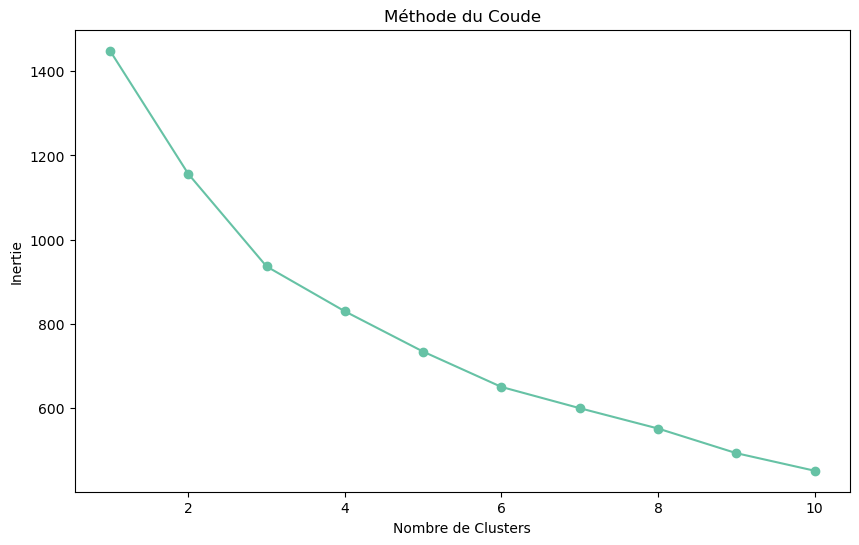

In [28]:
# Calcul des inerties pour différents nombres de clusters
inertie = []
for i in range(1, 11):  # Essayer de 1 à 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_scaled2)
    inertie.append(kmeans.inertia_)

# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertie, marker='o')
plt.title('Méthode du Coude')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie')
plt.show()

- Comme précédement, nous observons un ralentissement à 3 et à 6 clusters

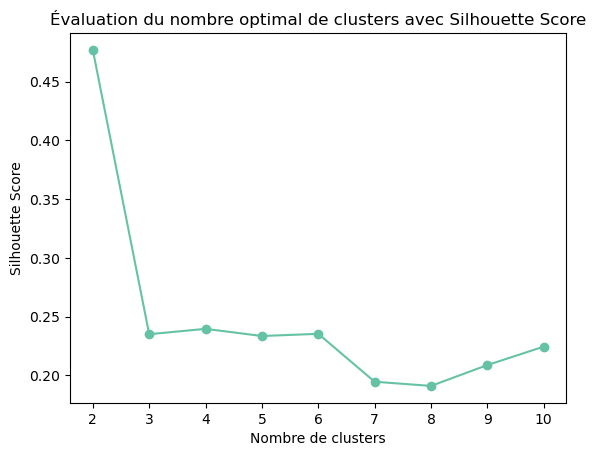

In [29]:
# Liste pour stocker nos coefficients
silhouettes = []

# Boucle itérative de 2 à 10 (clusters) pour tester les possibilités
for k in range(2, 11):
    # Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k, init='k-means++')
    cls.fit(X_scaled2)

    # Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled2, cls.labels_)
    silhouettes.append(silh)

# Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.plot(range(2, 11), silhouettes, marker='o')
plt.title('Évaluation du nombre optimal de clusters avec Silhouette Score')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

- Après exclusion des USA et de l'Inde, et en fonction de la méthode du coude ainsi que de la silouhette, nous décidons de découper nos données en 6 clusters

### Dendogramme de visualisation

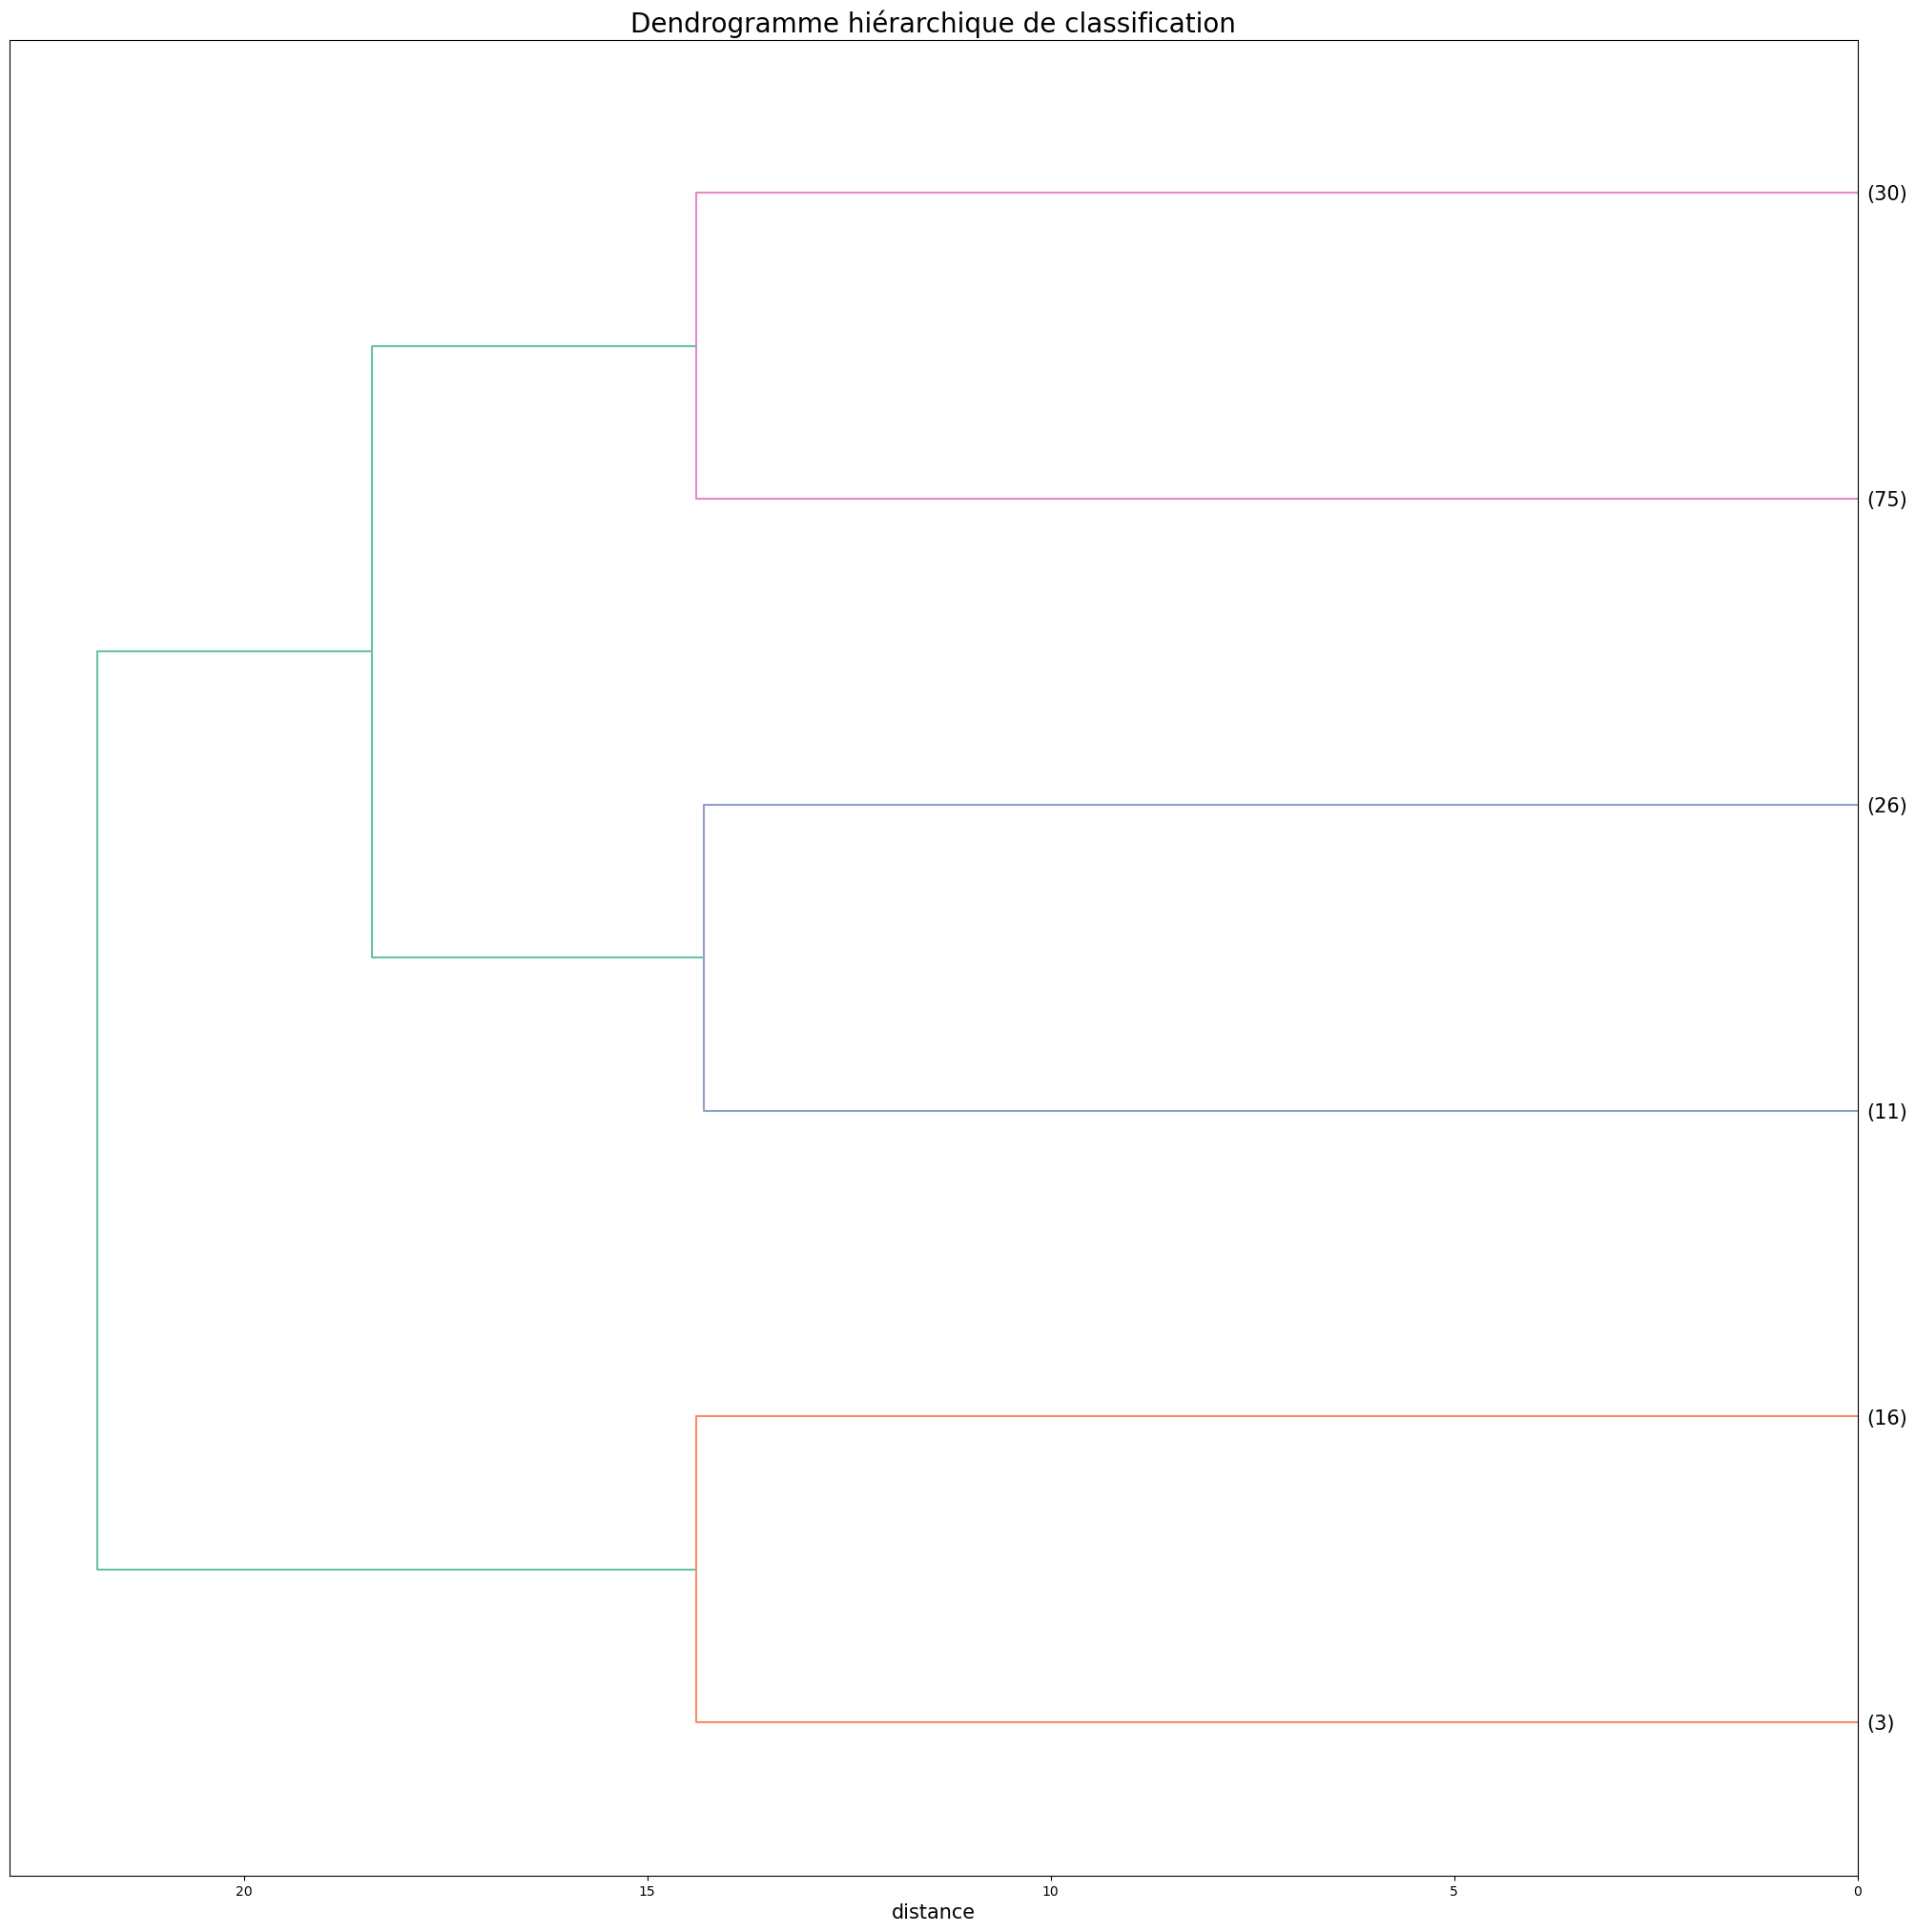

In [30]:
fig = plt.figure(figsize=(25,25))
plt.title('Dendrogramme hiérarchique de classification', fontsize=20)
plt.xlabel('distance', fontsize=15)

dendrogram(Z2, labels = df2.index, p=6, truncate_mode='lastp', leaf_font_size=15, orientation='left')
plt.show()

- Nos 6 clusters regroupent respectivement 30, 75, 26, 11, 16 et 3 pays,
- Il n'y a désormais plus aucun pays occupant un cluster individuel

In [31]:
cluster2 = fcluster(Z2, t=6, criterion='maxclust')
df2_cluster = pd.DataFrame({'Zone' : df2.index.tolist(),'cluster' : cluster2})
df2_cluster = df2_cluster.sort_values(['cluster', 'Zone'])
df2_cluster

Zone  cluster
4                                            Allemagne        1
71                                               Japon        1
115  Royaume-Uni de Grande-Bretagne et d'Irlande du...        1
1                                       Afrique du Sud        2
7                                      Arabie saoudite        2
..                                                 ...      ...
148                                            Ukraine        6
149                                            Uruguay        6
154                                             Zambie        6
156                                             Égypte        6
159                                           Éthiopie        6

[161 rows x 2 columns]

### Standardisation des données

In [32]:
ss = preprocessing.StandardScaler()
df2_stand = pd.DataFrame(ss.fit_transform(df2),columns = df2.columns, index=df2.index) 
# Standardisation du données df2 dans un df "df2_stand"

df2_stand_clust = pd.merge(df2_cluster, df2_stand , on='Zone')
df2_stand_clust
# Création d'un df "df2_stand_clust" qui joint les clusters au dataframe standardisé

Zone  cluster  \
0                                            Allemagne        1   
1                                                Japon        1   
2    Royaume-Uni de Grande-Bretagne et d'Irlande du...        1   
3                                       Afrique du Sud        2   
4                                      Arabie saoudite        2   
..                                                 ...      ...   
156                                            Ukraine        6   
157                                            Uruguay        6   
158                                             Zambie        6   
159                                             Égypte        6   
160                                           Éthiopie        6   

     Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                            -0.037148        
1                                            -0.099162        
2                                             0.760086        
3                                             0.999832        
4                                             1.490192        
..                                                 ...        
156                                           0.164238        
157                                          -0.698846        
158                                          -1.063260        
159                                          -0.453347        
160                                          -1.273597        

     Nourriture (Milliers T)  Population  Stabilité politique (indice)  \
0                   1.147620    1.338584                      0.731816   
1                   1.882194    2.389692                      1.302863   
2                   1.658884    0.965178                      0.512183   
3                   1.564858    0.737405                     -0.223590   
4                   0.977199    0.177011                     -0.618930   
..                       ...         ...                           ...   
156                 0.557023    0.443900                     -1.969676   
157                -0.397923   -0.518297                      1.236973   
158                -0.371478   -0.203817                      0.248622   
159                 0.796004    1.661672                     -1.475500   
160                -0.414573    1.895062                     -1.761024   

     PIB (Mrd $)  Import - Prix - (M $)  Distance à la France (km)  \
0       5.515078               5.809980                  -1.440921   
1       7.508534               4.546082                   1.003263   
2       3.895460               4.854266                  -1.466440   
3       0.193789               1.182878                   0.905325   
4       0.688516               4.523623                  -0.321027   
..           ...                    ...                        ...   
156    -0.238282              -0.166813                  -1.023653   
157    -0.315218              -0.420587                   1.331443   
158    -0.376897              -0.396200                   0.445031   
159    -0.104776               0.121113                  -0.710404   
160    -0.295025              -0.420604                  -0.087288   

     Indice Import (Valeur, 2015)  PIB_hab ($)  
0                       -0.062866     1.626589  
1                       -0.081186     1.313804  
2                       -0.319353     1.394461  
3                        0.523391    -0.359701  
4                       -0.704085     0.379024  
..                            ...          ...  
156                      0.047057    -0.577357  
157                      3.564601     0.268568  
158                      0.944764    -0.628867  
159                     -0.282712    -0.603316  
160                      0.926443    -0.671402  

[161 rows x 11 columns]

In [33]:
df2_cluster_1 = df2_stand_clust[df2_stand_clust['cluster'] == 1]
number_countries_1 = len(df2_cluster_1)
print(f"Il y a {number_countries_1} pays dans le cluster 1")

df2_cluster_2 = df2_stand_clust[df2_stand_clust['cluster'] == 2]
number_countries_2 = len(df2_cluster_2)
print(f"Il y a {number_countries_2} pays dans le cluster 2")

df2_cluster_3 = df2_stand_clust[df2_stand_clust['cluster'] == 3]
number_countries_3 = len(df2_cluster_3)
print(f"Il y a {number_countries_3} pays dans le cluster 3")

df2_cluster_4 = df2_stand_clust[df2_stand_clust['cluster'] == 4]
number_countries_4 = len(df2_cluster_4)
print(f"Il y a {number_countries_4} pays dans le cluster 4")

df2_cluster_5 = df2_stand_clust[df2_stand_clust['cluster'] == 5]
number_countries_5 = len(df2_cluster_5)
print(f"Il y a {number_countries_5} pays dans le cluster 5")

df2_cluster_6 = df2_stand_clust[df2_stand_clust['cluster'] == 6]
number_countries_6 = len(df2_cluster_6)
print(f"Il y a {number_countries_6} pays dans le cluster 6")

Il y a 3 pays dans le cluster 1
Il y a 16 pays dans le cluster 2
Il y a 11 pays dans le cluster 3
Il y a 26 pays dans le cluster 4
Il y a 75 pays dans le cluster 5
Il y a 30 pays dans le cluster 6


<h2 style="font-size:19px;color:blue"> Heatmap de corrélation </h2>

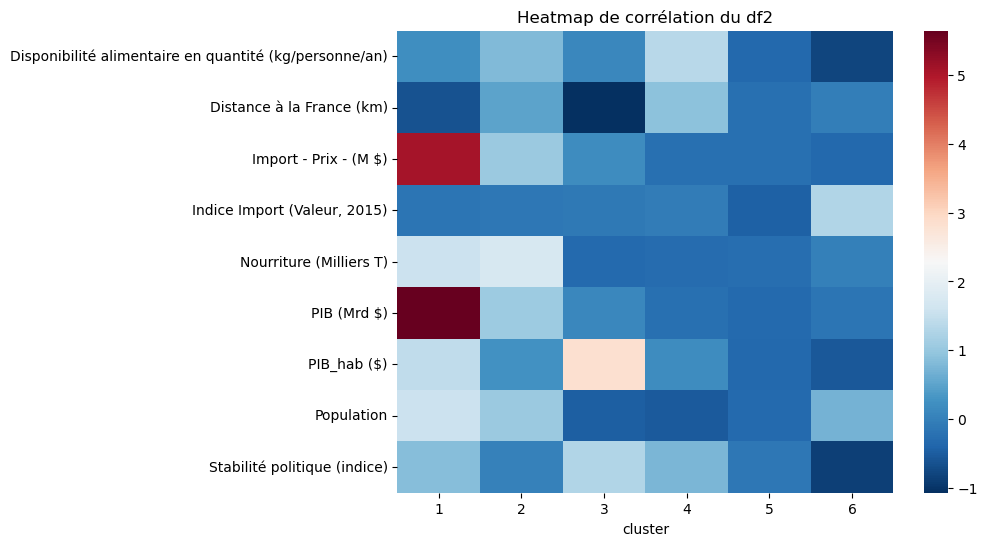

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(df2_stand_clust.pivot_table(columns="cluster", aggfunc='mean', fill_value=0), cmap="RdBu_r")
plt.title("Heatmap de corrélation du df2")
plt.show()

- Cluster 1 : Représente des pays aux très fortes données d'imports et PIB. Nourriture, PIB/hab, Population et statibilité politique plutôt élevés. 
- Cluster 2 : Pays dont les Imports, Nourriture, PIB, Population, disponibilité alimentaire ainsi quee distance par rapport à la France plus élevées que la moyenne.
- Cluster 3 : PIB par habitants élevé et stabilité politique légèrement au dessus des moyennes
- Cluster 4 : Dispo alimentaire ainsi qu'à la distance par rapport à la France légèrement au dessus des moyennes.
- Cluster 5 : Pays dont les variables sont toutes en dessous des moyennes mondiales
- Cluster 6 : Moyenne sensibilité à l'indice importation, à la Population et Stabilité politique très faible.

###### Selon les premières analyses, les pays du cluster 1 et 3 semblent être des zones interessantes pour exporter notre production

In [35]:
df2_clust_1_3 = df2_stand_clust.loc[df2_stand_clust['cluster'].isin([1, 3])]
df2_clust_1_3

Zone  cluster  \
0                                           Allemagne        1   
1                                               Japon        1   
2   Royaume-Uni de Grande-Bretagne et d'Irlande du...        1   
19                                           Autriche        3   
20                                           Belgique        3   
21                               Chine - RAS de Macao        3   
22                                           Danemark        3   
23                                           Finlande        3   
24                                            Irlande        3   
25                                            Islande        3   
26                                         Luxembourg        3   
27                                            Norvège        3   
28                                             Suisse        3   
29                                              Suède        3   

    Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                           -0.037148        
1                                           -0.099162        
2                                            0.760086        
19                                          -0.118342        
20                                          -0.473166        
21                                           0.921835        
22                                           0.570847        
23                                          -0.082540        
24                                           0.368821        
25                                           0.632861        
26                                          -0.110031        
27                                          -0.064000        
28                                          -0.276894        
29                                          -0.220634        

    Nourriture (Milliers T)  Population  Stabilité politique (indice)  \
0                  1.147620    1.338584                      0.731816   
1                  1.882194    2.389692                      1.302863   
2                  1.658884    0.965178                      0.512183   
19                -0.271576   -0.392119                      1.236973   
20                -0.287247   -0.331181                      0.556109   
21                -0.407717   -0.584256                      1.654277   
22                -0.265700   -0.464490                      1.039303   
23                -0.327404   -0.469668                      1.269918   
24                -0.307815   -0.487437                      1.182065   
25                -0.418491   -0.591011                      1.566423   
26                -0.417512   -0.584975                      1.544460   
27                -0.329363   -0.474708                      1.368753   
28                -0.298021   -0.400653                      1.467588   
29                -0.267659   -0.366688                      1.160101   

    PIB (Mrd $)  Import - Prix - (M $)  Distance à la France (km)  \
0      5.515078               5.809980                  -1.440921   
1      7.508534               4.546082                   1.003263   
2      3.895460               4.854266                  -1.466440   
19     0.252323               0.690594                  -1.284241   
20     0.389782               1.503559                  -1.487646   
21    -0.337392              -0.259649                   0.970702   
22     0.115448               0.162968                  -1.286224   
23    -0.007493              -0.300073                  -1.053662   
24     0.122291               0.608785                  -1.351872   
25    -0.378729              -0.404430                  -0.968488   
26    -0.312842              -0.276431                  -1.480613   
27     0.221991              -0.414981                  -1.203236   
28     0.714065               0.219344                  -1.441926   
29     0.451281               0.300418                  -1.149827

<h2 style="font-size:19px;color:blue"> Nuages de points des différentes variables </h2>

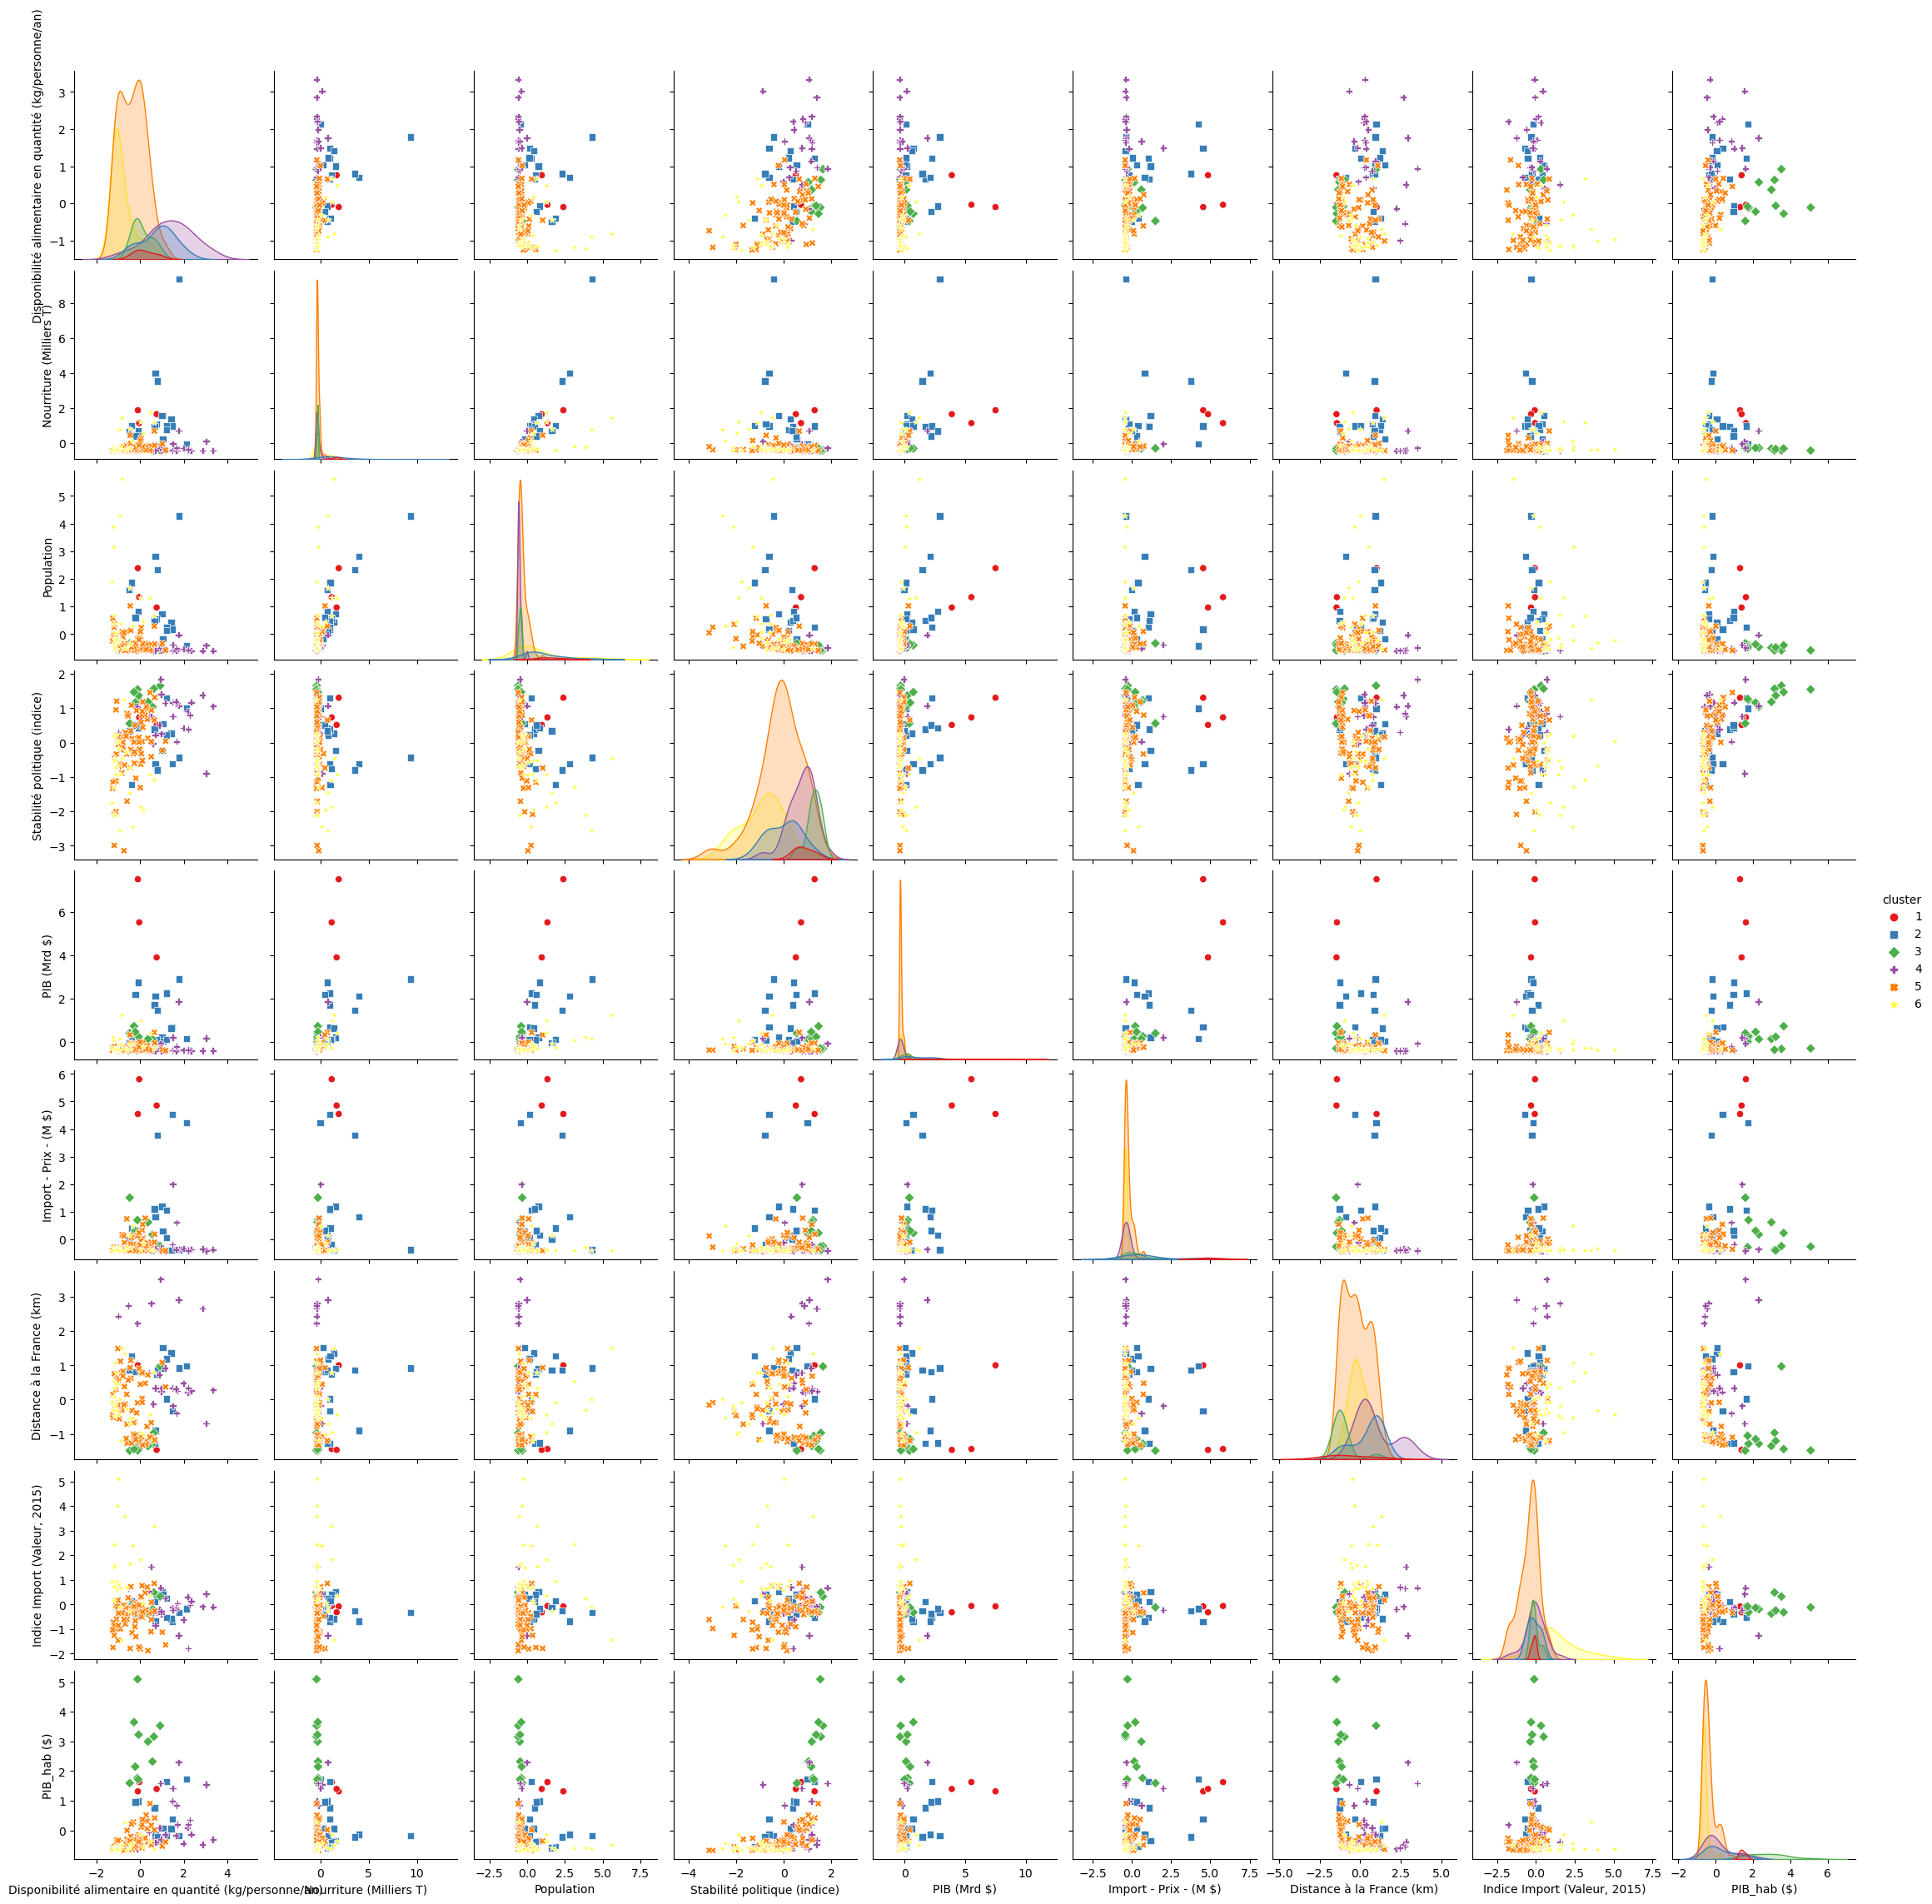

In [36]:
cluster_palette = sns.color_palette("Set1", n_colors=6)
sns.pairplot(df2_stand_clust, hue="cluster", palette=cluster_palette, markers=["o", "s", "D", "P", "X", "*"])
#plt.show()

<h2 style="font-size:19px;color:blue"> Box-plot des différentes variables </h2>

<AxesSubplot:xlabel='cluster', ylabel='Stabilité politique (indice)'>

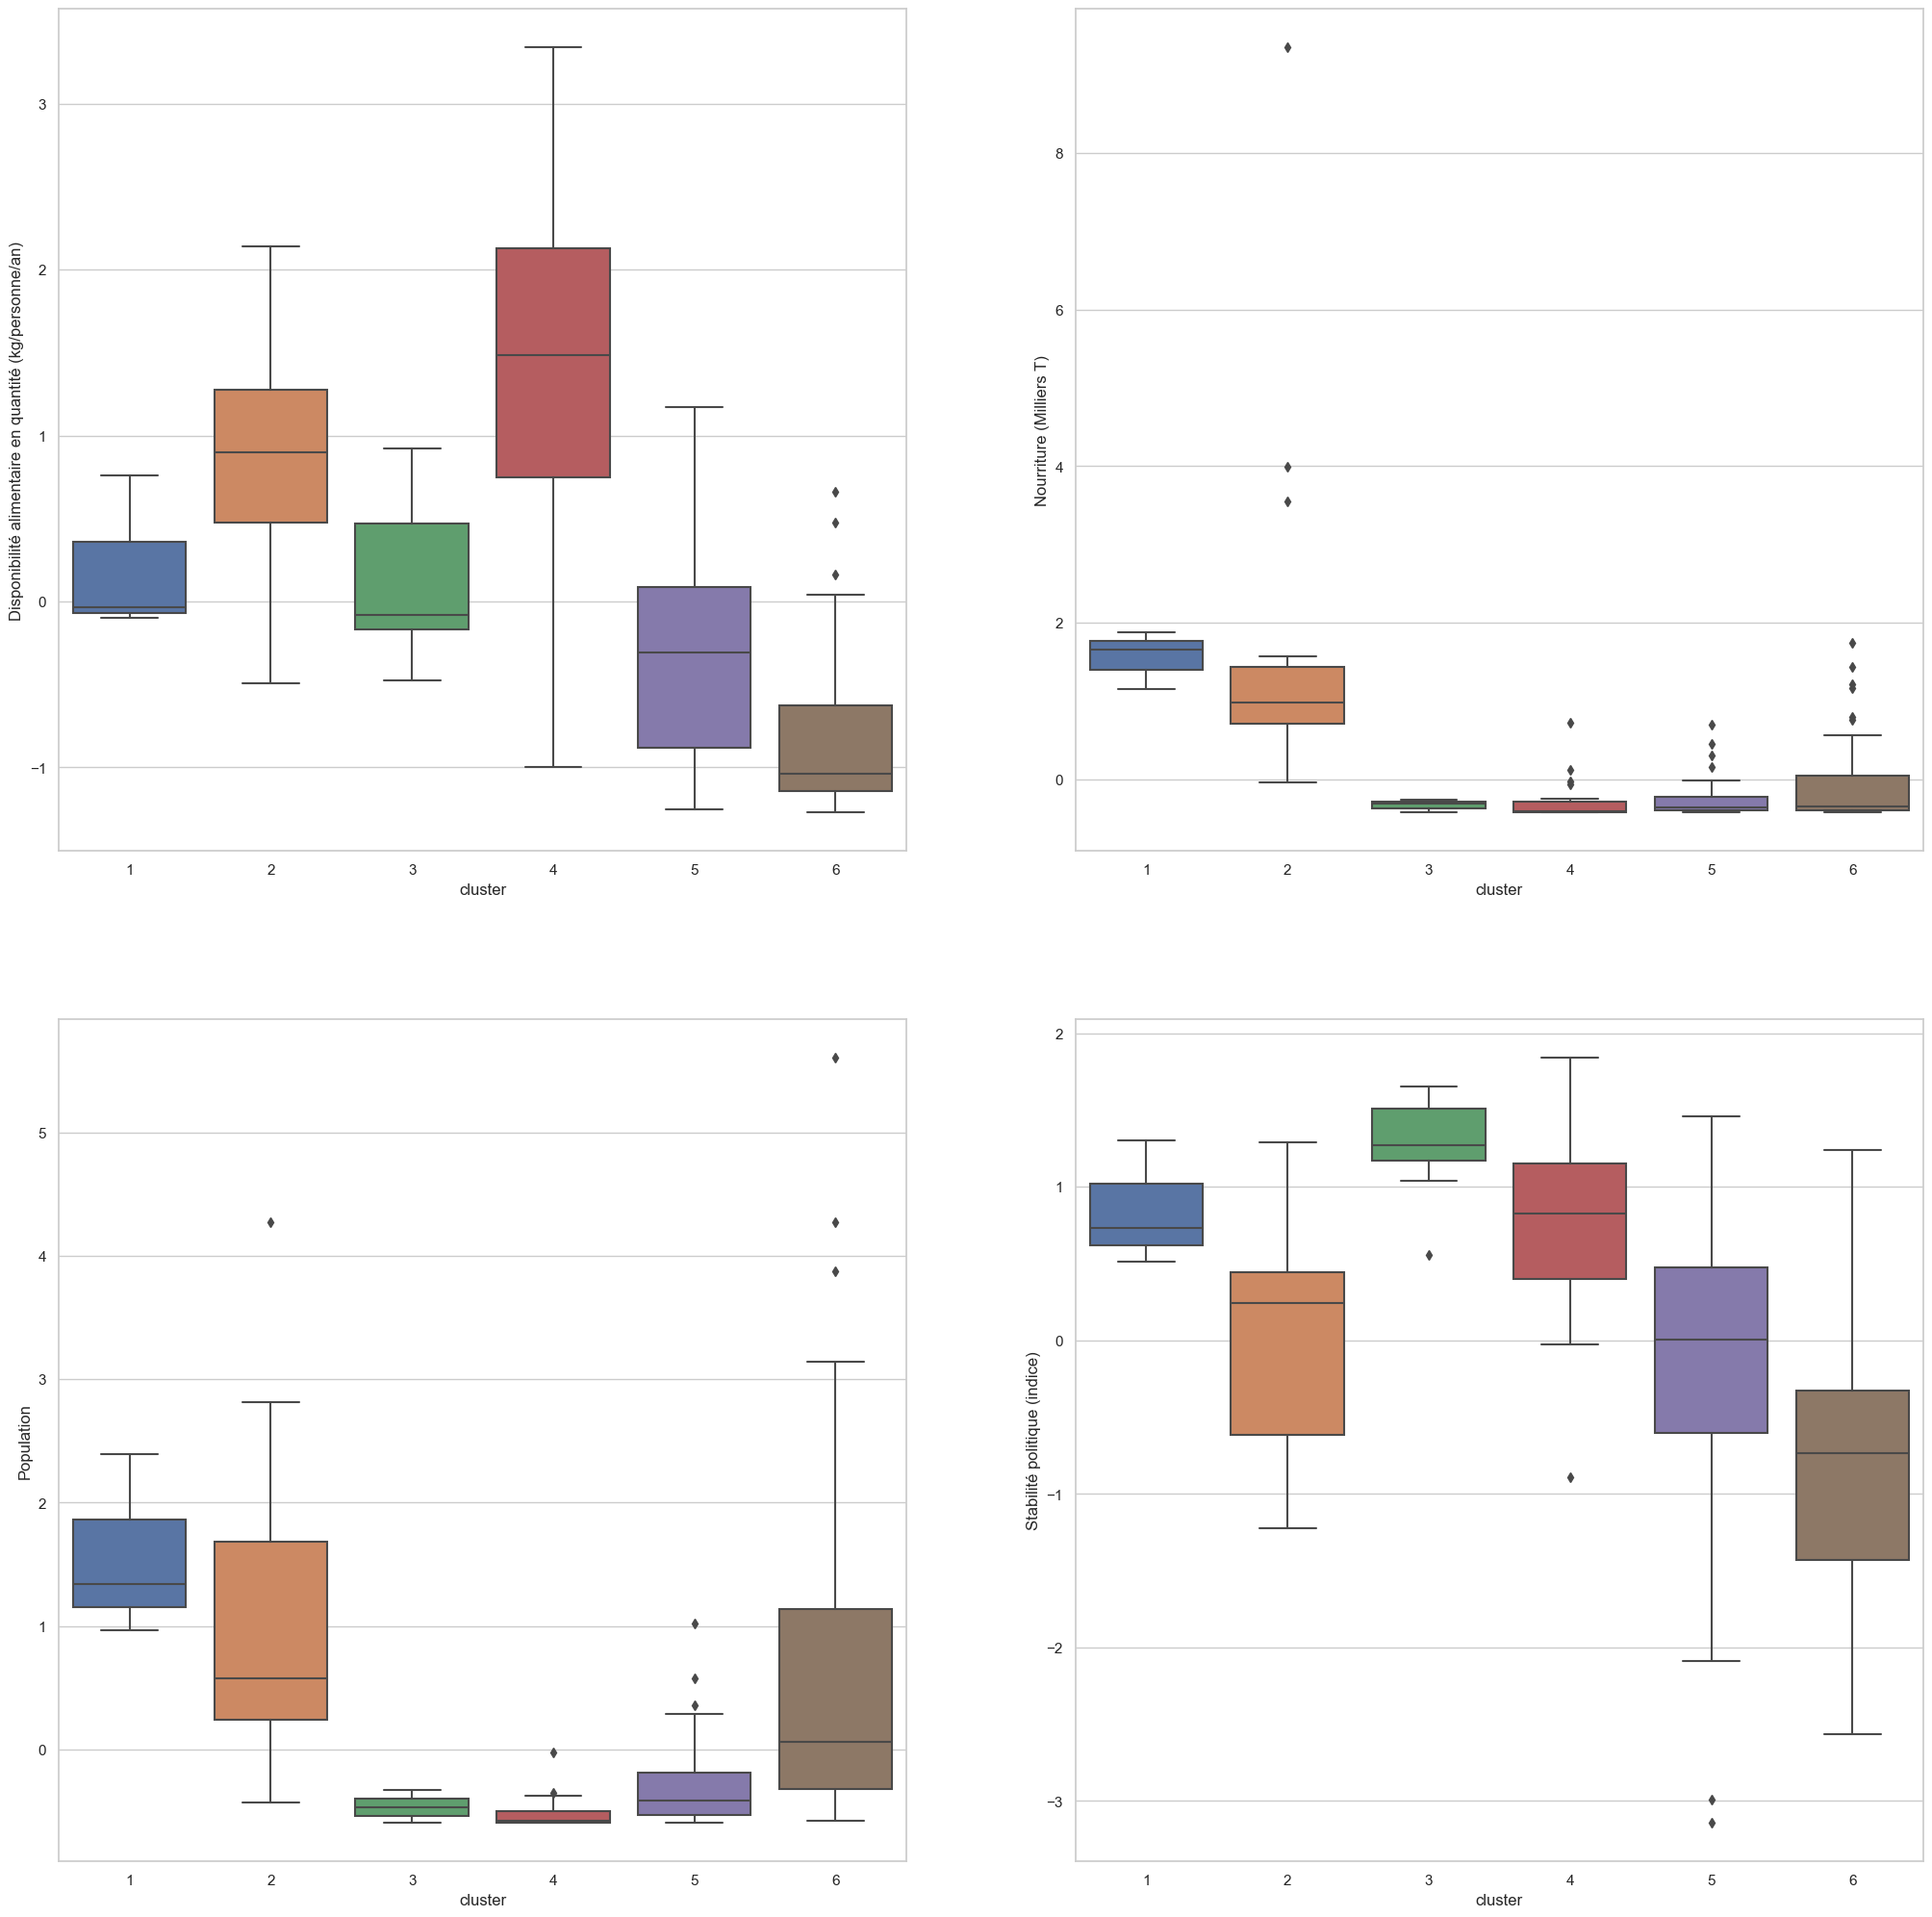

In [38]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les numéros des groupes
plt.figure(figsize=(25, 25))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df2_stand_clust, x='cluster', y='Disponibilité alimentaire en quantité (kg/personne/an)')

plt.subplot(222)
sns.boxplot(data=df2_stand_clust, x='cluster', y='Nourriture (Milliers T)')

plt.subplot(223)
sns.boxplot(data=df2_stand_clust, x='cluster', y='Population')

plt.subplot(224)
sns.boxplot(data=df2_stand_clust, x='cluster', y='Stabilité politique (indice)')

<AxesSubplot:xlabel='cluster', ylabel='Indice Import (Valeur, 2015)'>

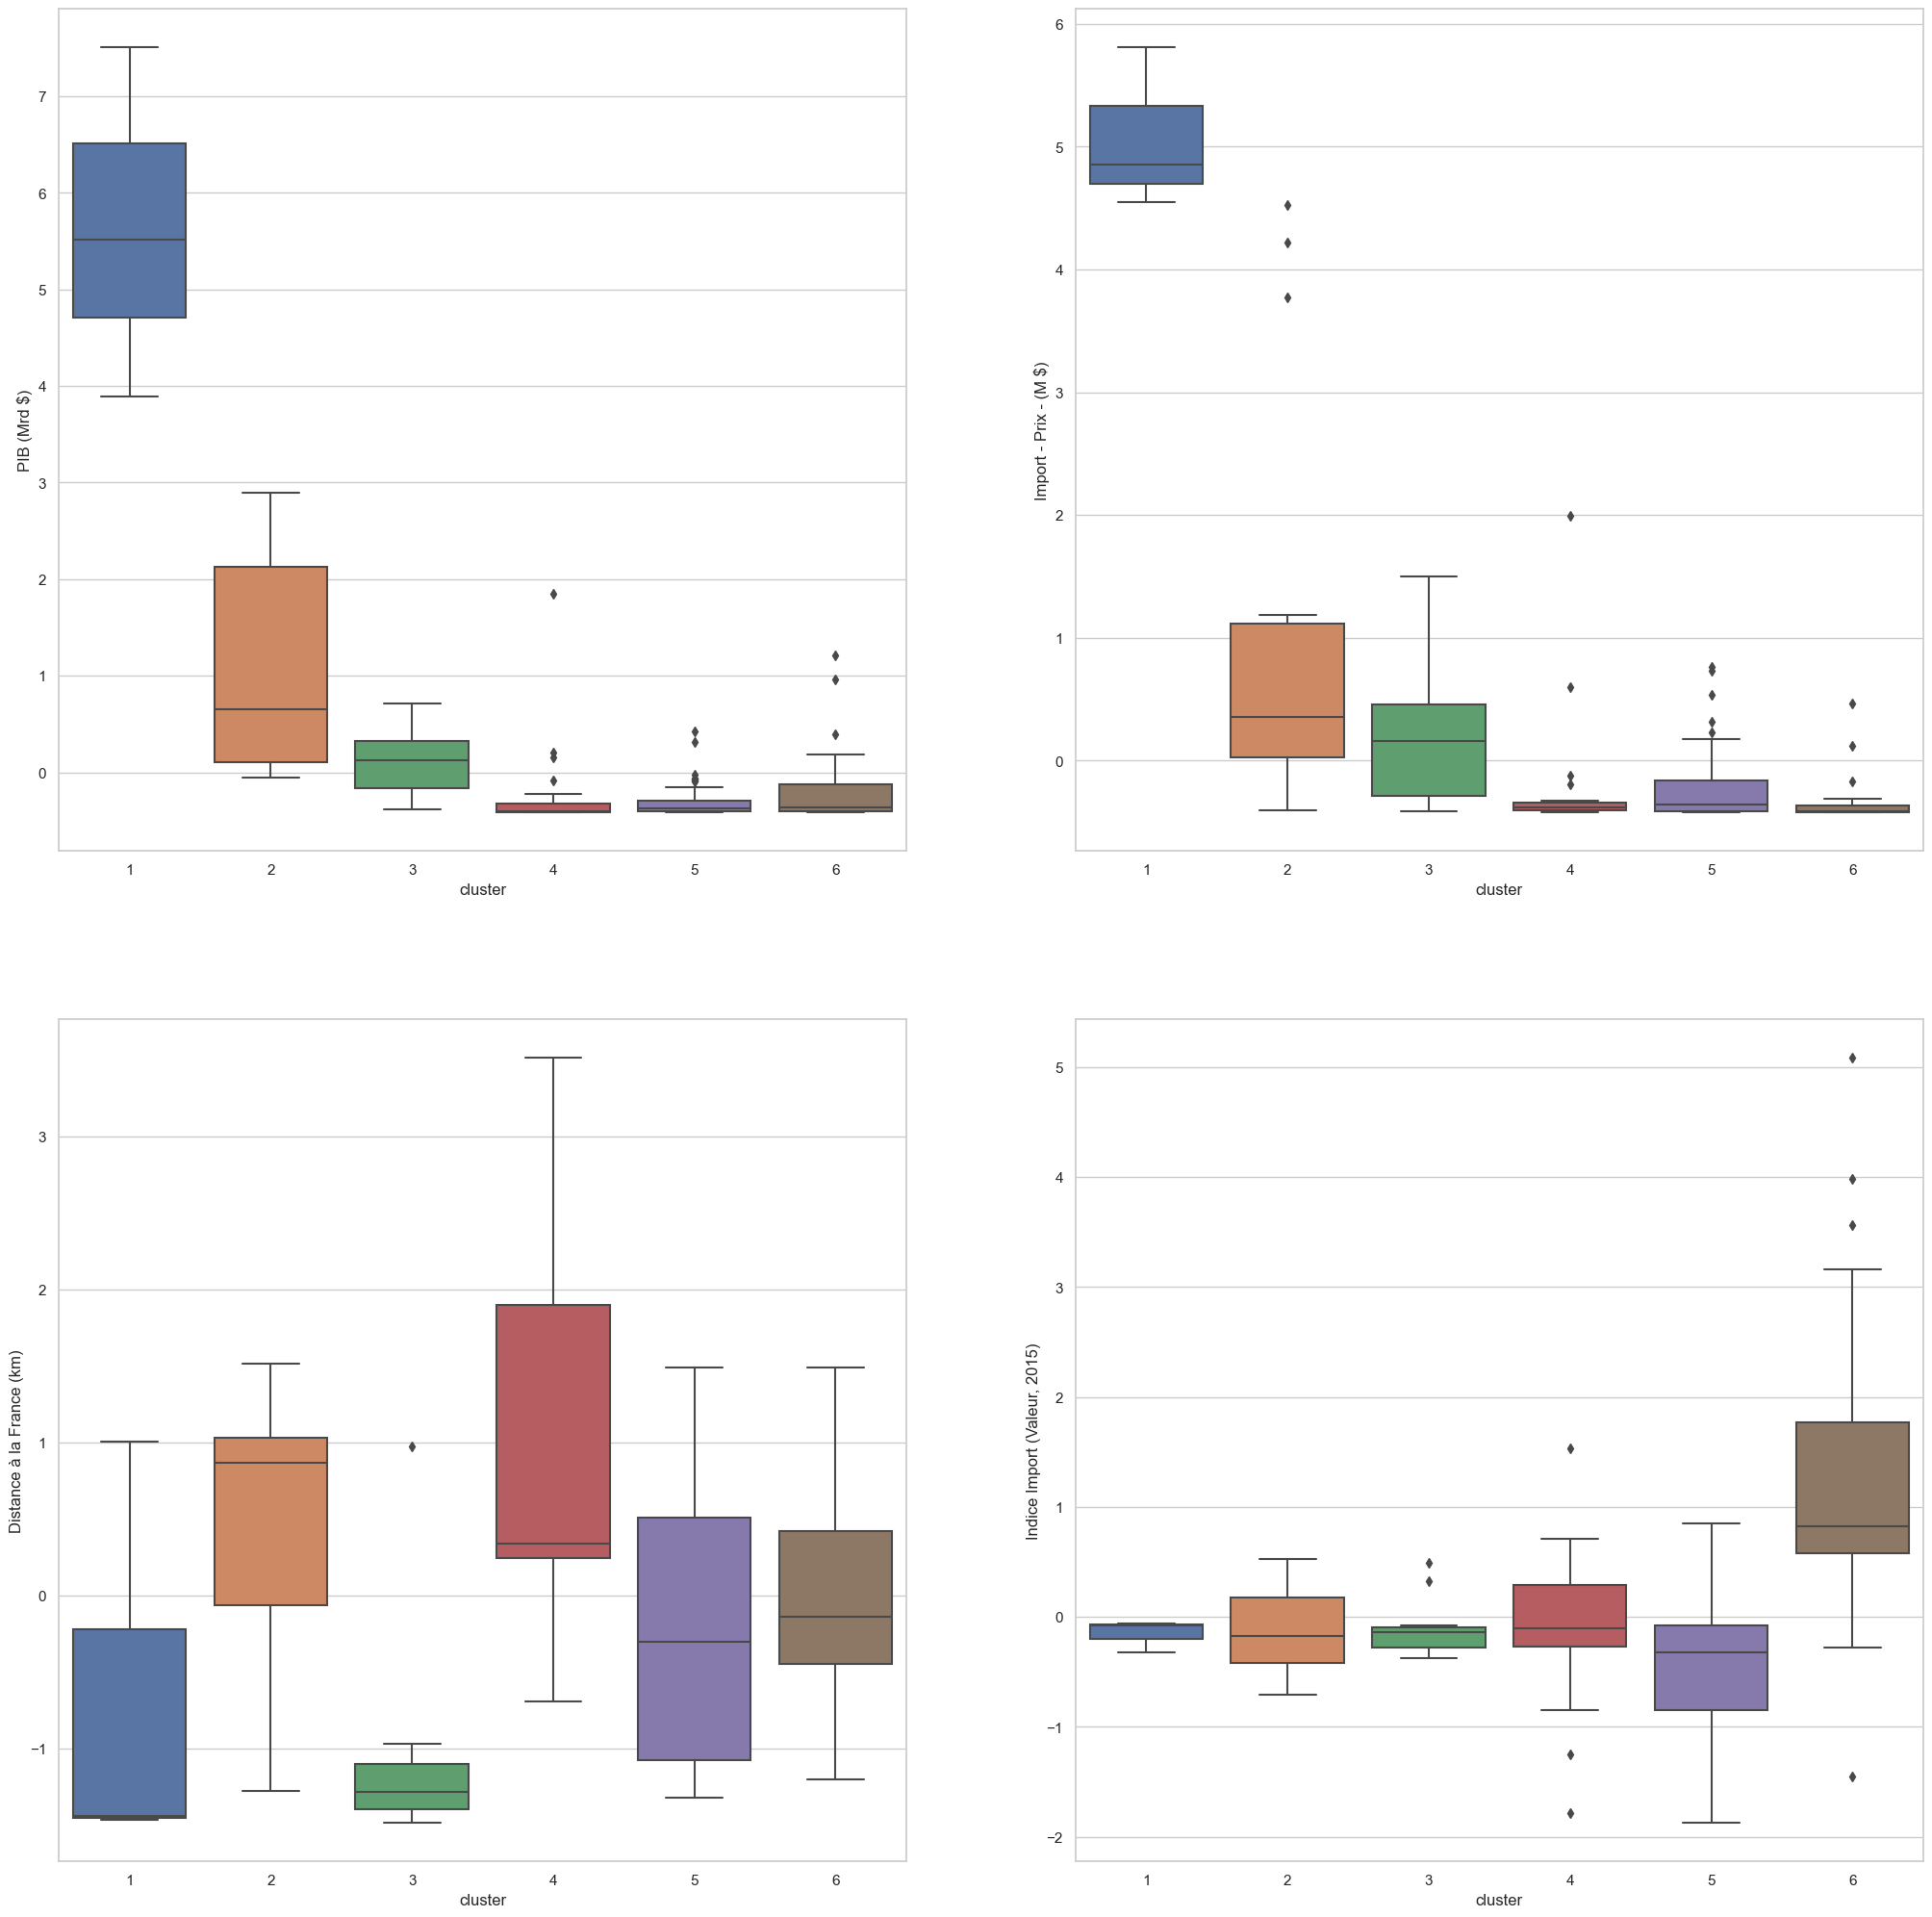

In [39]:
plt.figure(figsize=(25, 25))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df2_stand_clust, x='cluster', y='PIB (Mrd $)')

plt.subplot(222)
sns.boxplot(data=df2_stand_clust, x='cluster', y='Import - Prix - (M $)')

plt.subplot(223)
sns.boxplot(data=df2_stand_clust, x='cluster', y='Distance à la France (km)')

plt.subplot(224)
sns.boxplot(data=df2_stand_clust, x='cluster', y='Indice Import (Valeur, 2015)')

<AxesSubplot:xlabel='cluster', ylabel='PIB_hab ($)'>

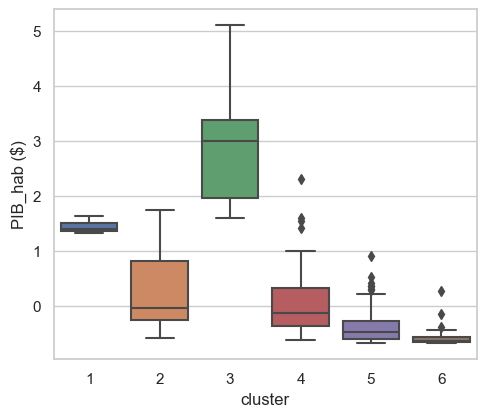

In [40]:
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

plt.subplot(221)
sns.boxplot(data=df2_stand_clust, x='cluster', y='PIB_hab ($)')

<h1 style="font-size:22px;color:red"> Analyse en Composante Principale (ACP) </h1>

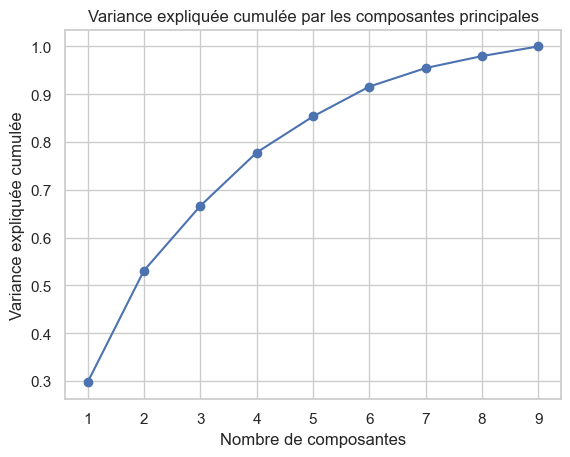

In [41]:
pca = PCA()
pca_result = pca.fit_transform(df2_stand)

# Variance expliquée
explained_var_ratio = pca.explained_variance_ratio_

# Graph
cumulative_explained_var_ratio = explained_var_ratio.cumsum()
plt.plot(range(1, len(cumulative_explained_var_ratio) + 1), cumulative_explained_var_ratio, marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée par les composantes principales')
plt.show()

- Le graphique des valeurs propres, également appelé "scree plot" ou "éboulis", offre une visualisation de la manière dont la variance des données est expliquée à mesure que davantage de composantes principales sont incluses. 
- L'analyse de nos données révèle que l'utilisation de 2 facteurs permet de capturer environs 53% de l'information. 6 composantes permettent de capturer plus de 90% de l'information contenue dans les données et à partir de 9 composantes la totalité (100%) de l'information est capturée.

<h2 style="font-size:19px;color:blue"> Cercles de corrélations </h2>

In [42]:
#define PCA model to use
pca = PCA(n_components=6)

#fit PCA model to data
pca_fit = pca.fit(df2_stand)

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(26,26))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

### Cercle de corrélation de F1 et F2

- Les facteurs F1 et F2 représentent les deux premières composantes principales résultant de la décompositions de nos données dans des dimensions orthogonales. 
- F1 capture la plus grande information de nos données, suivis de F2, F3... jusqu'à F9, ou 100% de l'information sera capturé. 
- Nous avons vu précédement que les deux premières composantes (F1, F2) capturaient environs 50% de l'information

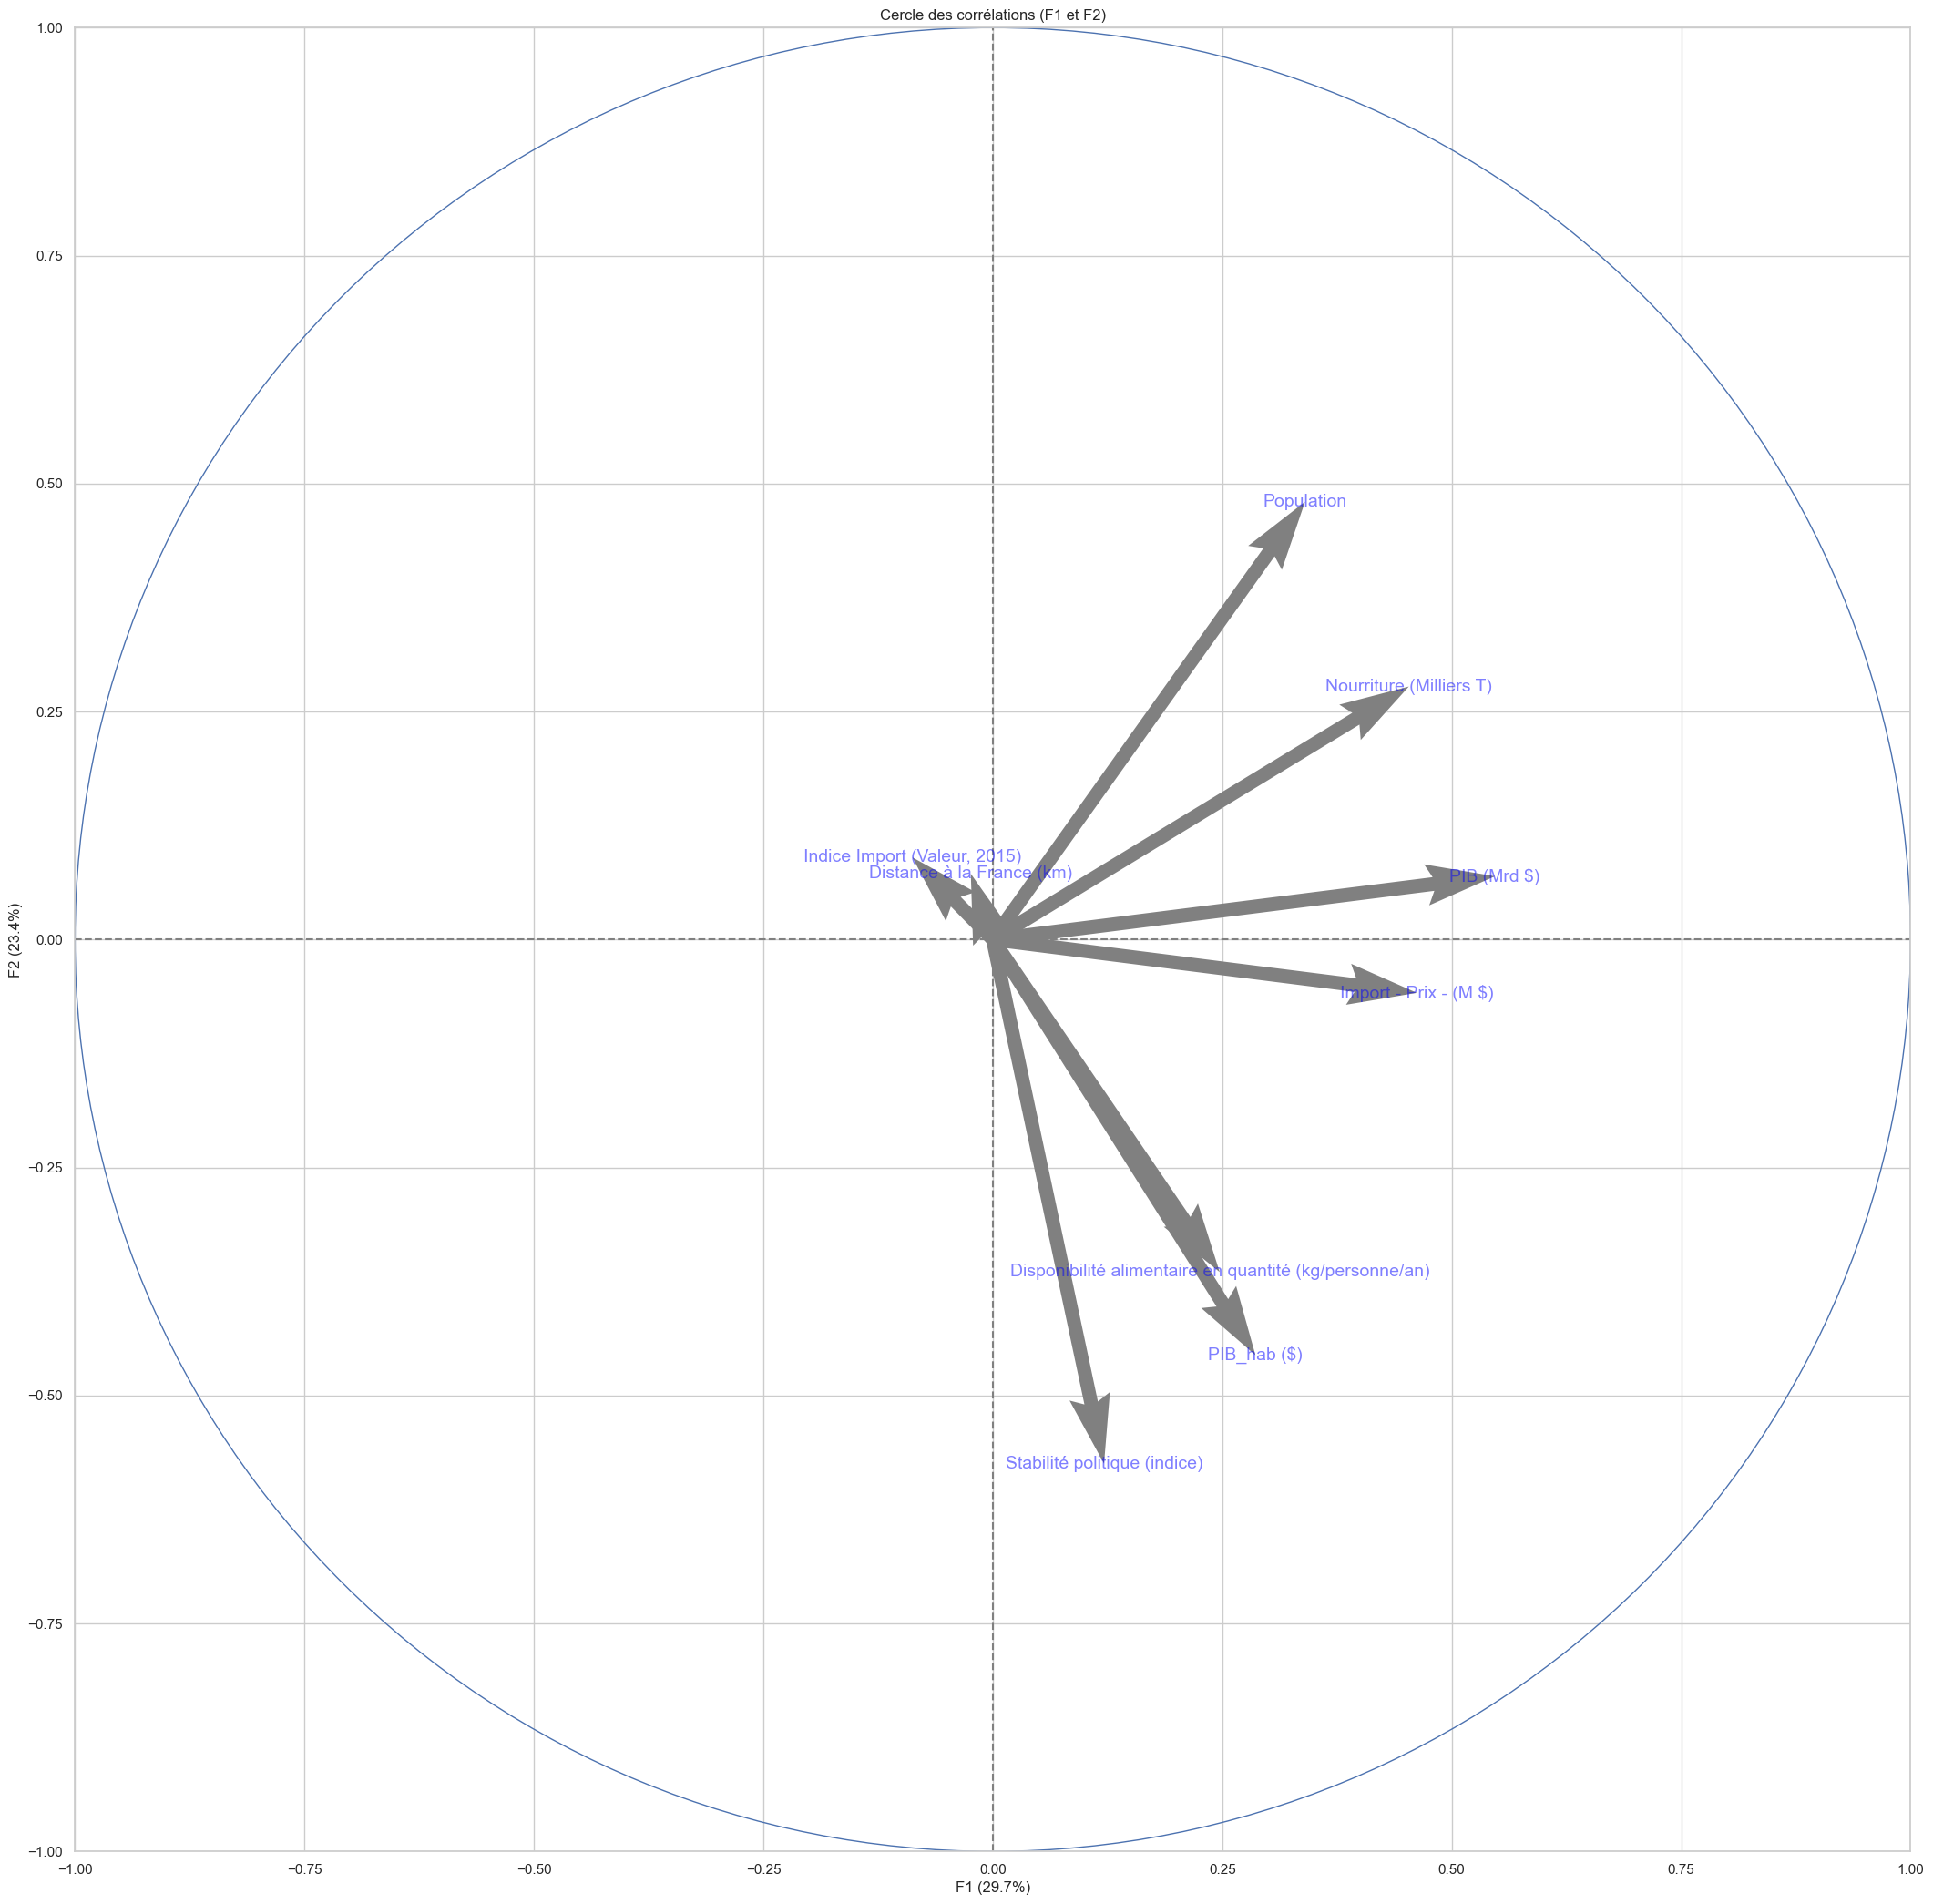

In [43]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 6, pca, [(0,1)],labels = np.array(df2_stand.columns))

- Ce premier cercle de corrélation (F1/F2) capture 53.1% de l'information de nos données. 
- Toutes les variables sont positivements corrélées à F1 sauf l'Indice import (Valeur, 2015) ainsi que la distance à la France, dont la longueur des flèches est trop petite pour être interprété. Les variables positivement corrélés sont particulièrement sensible à l'augmentation de F1.
- La Nourriture, le PIB ainsi que la Disponibilité alimentaire et le PIB par habitants sont les variables les plus corrélés à F1. Ces variables sont particulièrement sensible à l'augmentation de F1.
- La Population, Nourriture ainsi que le PIB sont positivement corrélés à F2, elles augmentent à mesure que F2 augmente, tandis que l'Import, la Disponibilité alimentaire, le PIB par habitant ainsi que la Stabilité politique sont négativement corrélés à F2.
- La Nourriture, le PIB, la Disponibilité alimentaire ou encore le PIB par habitants sont corrélés par F1 et F2 dans des proportions similaires. 

### Cercle de corrélation de F3 et F4

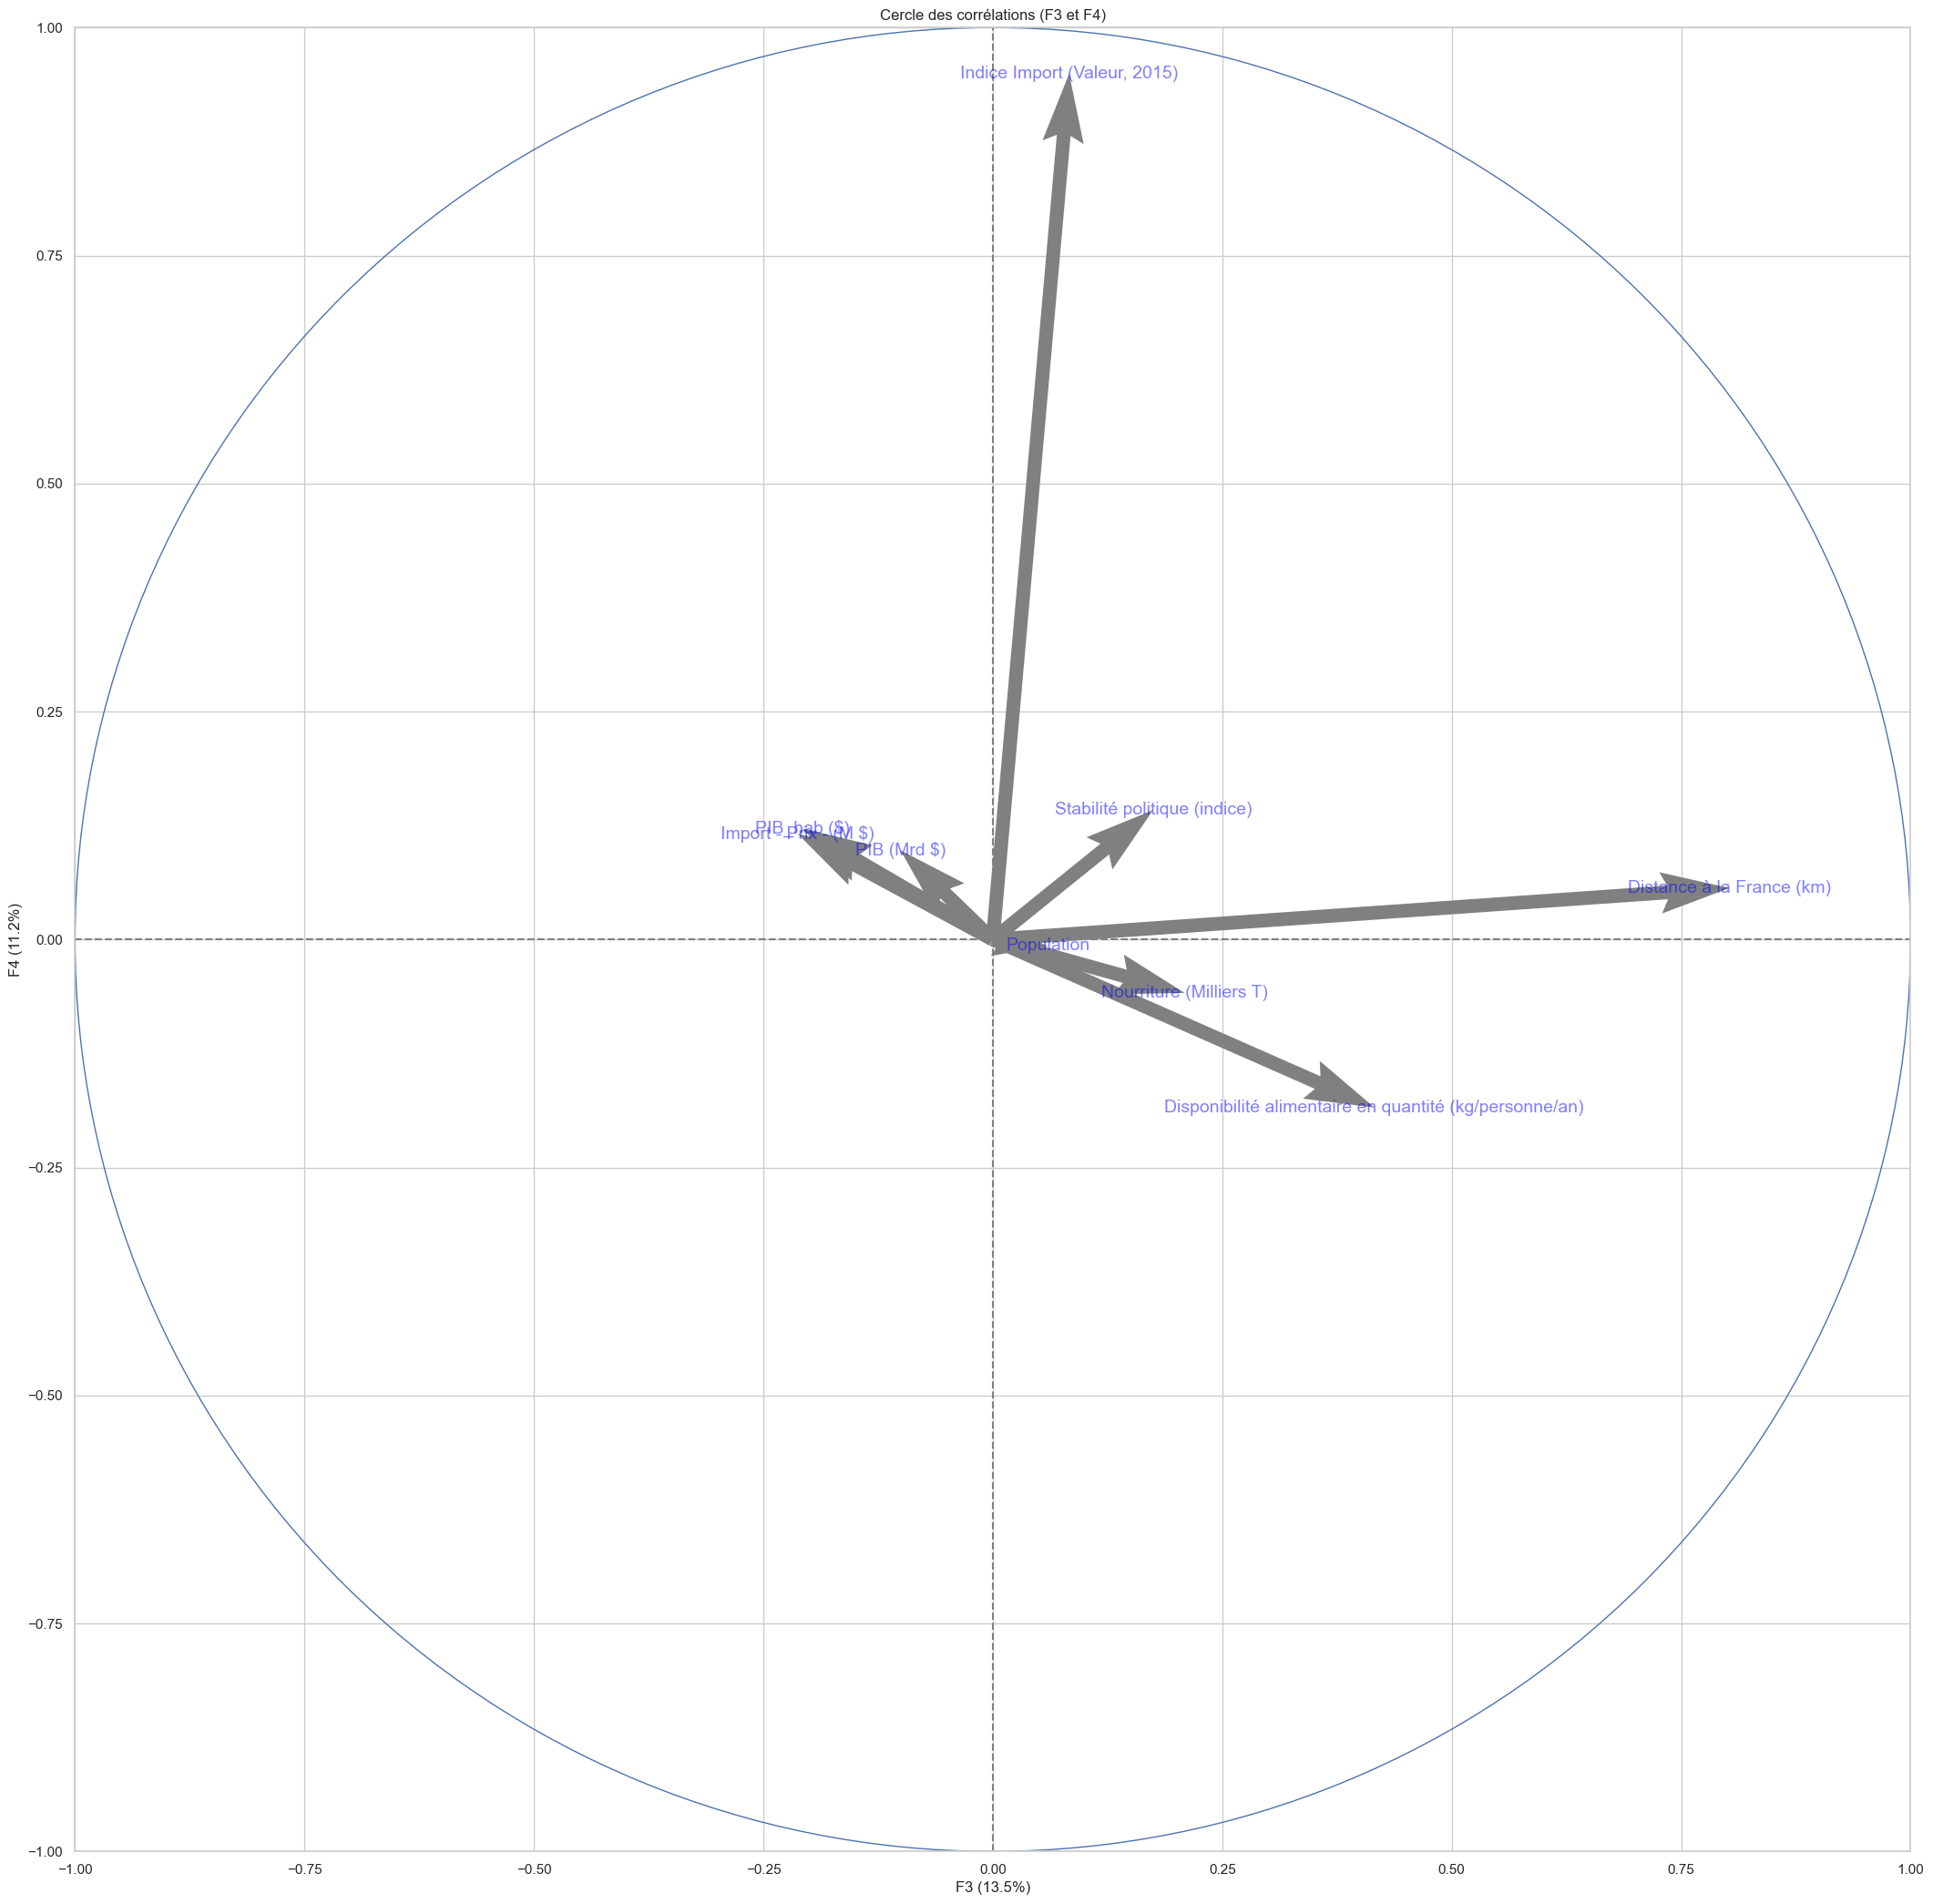

In [44]:
display_circles(pcs, 6, pca, [(2,3)],labels = np.array(df2_stand.columns))

- Sur ce nouveau plan othogonal (24.7% de l'information supplémentaire), la Disponibilité alimentaire ainsi que la Stabilité politique sont positivement corrélés à F1, tandis que la Distance à la France est fortement et positivement corrélées à F3. Ces valeurs augmentent à mesure que F3 augmente.

- l’angle formé par ces deux variables indiquent qu’il n’y a aucune corrélation entre elles
- La Population, la Nourriture ainsi que le PIB présente des flèches trop petites pour être interprétées. 
- Toujours sur l'axe F3, le PIB par habitants ainsi que l'Import sont les seules variables négativement corréles à F3. 
- Concernant F4, l'indice import est très fortement et positivement corrélé à F3. 

### Cercle de corrélation de F5 et F6

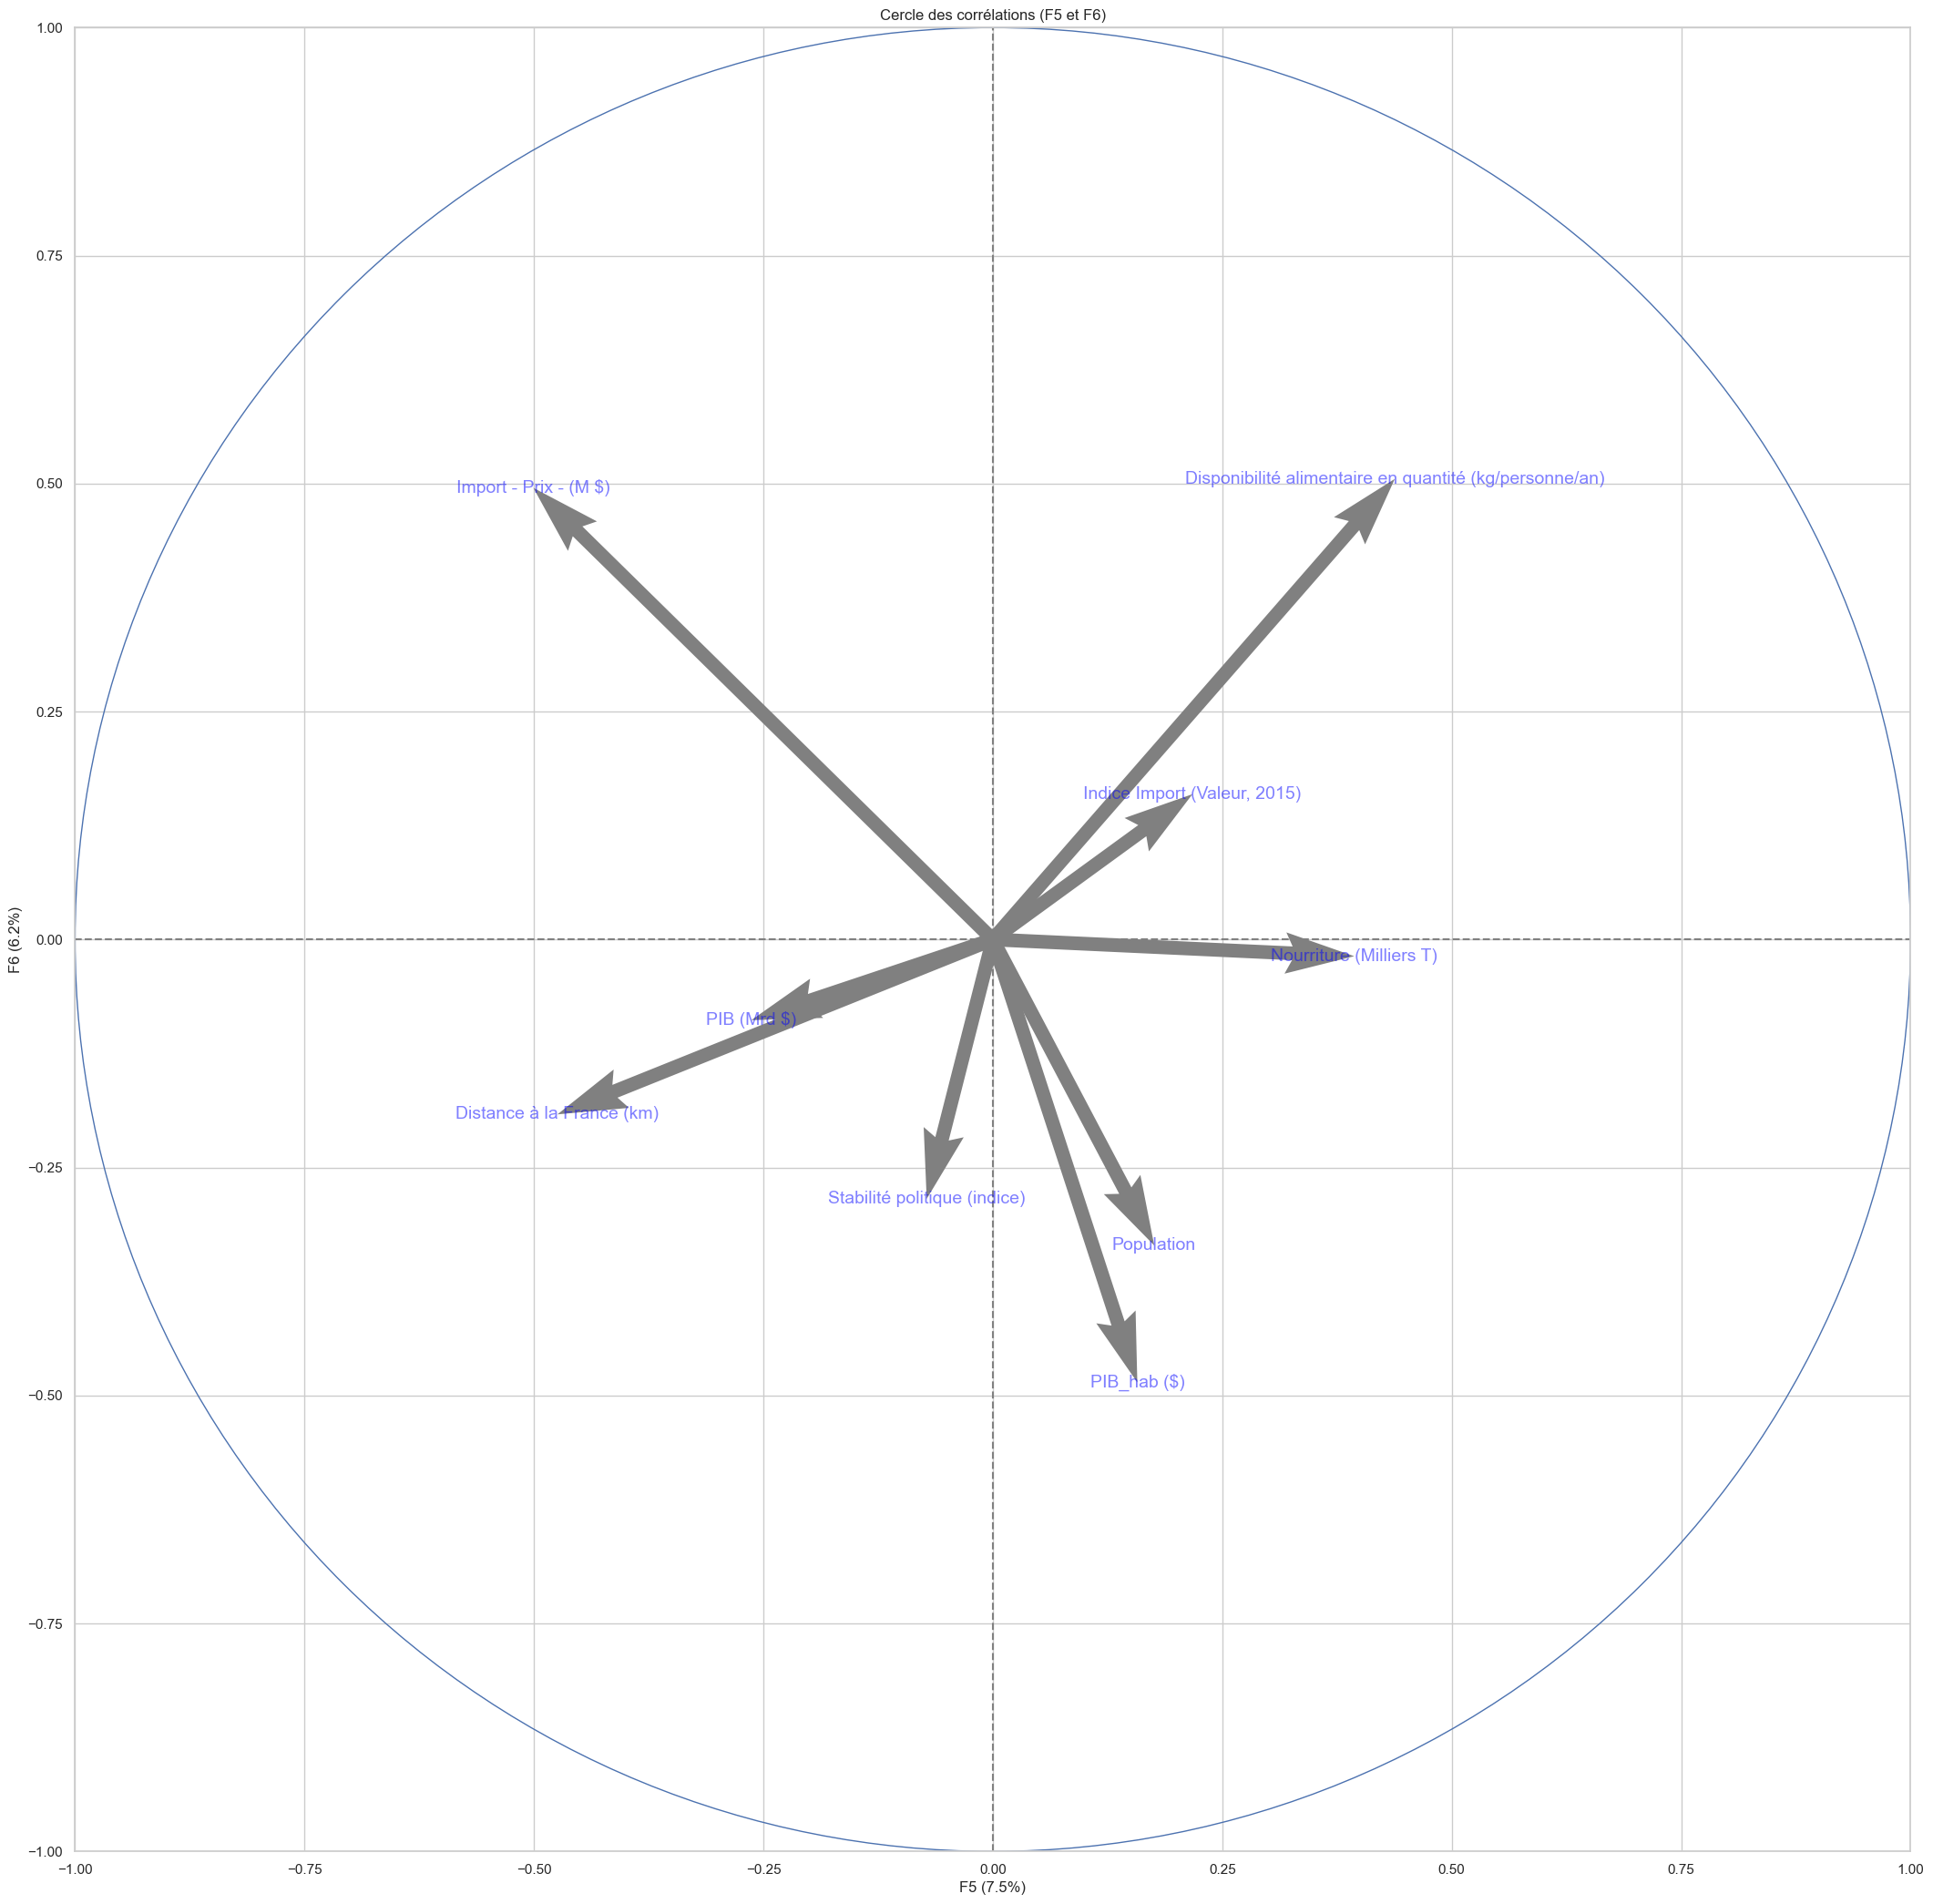

In [45]:
display_circles(pcs, 6, pca, [(4,5)],labels = np.array(df2_stand.columns))

- Enfin, ce troisième cercle de corrélation capture 15.2% de l'information supplémentaire, ce qui nous renvoie à un cumul de 89.3%.
- Ici, l'Import est très positivement corrélé à F5, ainsi que la distance à la france dans une moindre mesure.
- La Population est très positivement corrélé à F6, tandis que le PIB, la Nourriture ainsi que l'Indice Import (valeur 2015) est faiblement et négativement corrélé à F6. 
- Sur ce plan, la stabilité politique ainsi que le PIB par habitant sont autant corrélés positivement à F6 que corrélé négativement à F5. 

### Analyse issue des trois cercles de corrélation

- A l'aide de ces trois paires, l'analyse en composante principale (ACP) capture collectivement 89.3% de l'information contenu dans le jeu de données. 
- La première paire (F1, F2) semble être axé sur des variables économiques. L'import, la Nourriture, le PIB et la disponibilité alimentaire jouent un rôle important dans les corrélations. 
- La seconde paire (F3, F4) semble être plus politique et sociale. La stabilité politique, la distance à la France, la Disponibilité alimentaire ou encore le PIB par habitant ont une influence significative.  
- Enfin, la troisième paire apportent de l'information supplémentaire, capturant 15.2% de variance supplémentaire. L'importance de l'indice d'Import, la corrélation de la population avec F6 et les relations complexes entre la stabilité politique ainsi que le PIB par habitants sont mis en évidence. 
- Plusieurs variables se démarquent en tant qu'influentes à travers différentes paires.

<h1 style="font-size:22px;color:red"> La méthode des k-means </h1>

<h2 style="font-size:19px;color:blue"> Initialisation des kmeans </h2>

In [46]:
# Nombre de cluster souhaités
k = 6

# Création et entrainement du modèle sur df2_stand

kmeans = KMeans(n_clusters=k)
kmeans.fit(df2_stand)

# Ajout des labels et stockage dans un second dataframe
cluster_labels = kmeans.labels_
df2_stand['k_cluster'] = cluster_labels
df2_stand_k_clust = df2_stand.copy()

# Obtention des centroids
centroids = kmeans.cluster_centers_

### Stockage de chaque cluster dans un dataframe

In [47]:
df2_k_clust_0 = df2_stand_k_clust[df2_stand_k_clust['k_cluster'].isin([0])]
df2_k_clust_1 = df2_stand_k_clust[df2_stand_k_clust['k_cluster'].isin([1])]
df2_k_clust_2 = df2_stand_k_clust[df2_stand_k_clust['k_cluster'].isin([2])]
df2_k_clust_3 = df2_stand_k_clust[df2_stand_k_clust['k_cluster'].isin([3])]
df2_k_clust_4 = df2_stand_k_clust[df2_stand_k_clust['k_cluster'].isin([4])]
df2_k_clust_5 = df2_stand_k_clust[df2_stand_k_clust['k_cluster'].isin([5])]

### Nombre de pays par cluster

In [48]:
number_countries_0 = len(df2_k_clust_0)
print(f"Il y a {number_countries_0} pays dans le cluster 0")

number_countries_1 = len(df2_k_clust_1)
print(f"Il y a {number_countries_1} pays dans le cluster 1")

number_countries_2 = len(df2_k_clust_2)
print(f"Il y a {number_countries_2} pays dans le cluster 2")

number_countries_3 = len(df2_k_clust_3)
print(f"Il y a {number_countries_3} pays dans le cluster 3")

number_countries_4 = len(df2_k_clust_4)
print(f"Il y a {number_countries_4} pays dans le cluster 4")

number_countries_5 = len(df2_k_clust_5)
print(f"Il y a {number_countries_5} pays dans le cluster 5")

Il y a 29 pays dans le cluster 0
Il y a 25 pays dans le cluster 1
Il y a 3 pays dans le cluster 2
Il y a 32 pays dans le cluster 3
Il y a 6 pays dans le cluster 4
Il y a 66 pays dans le cluster 5


<h2 style="font-size:19px;color:blue"> Heatmap de corrélation </h2>

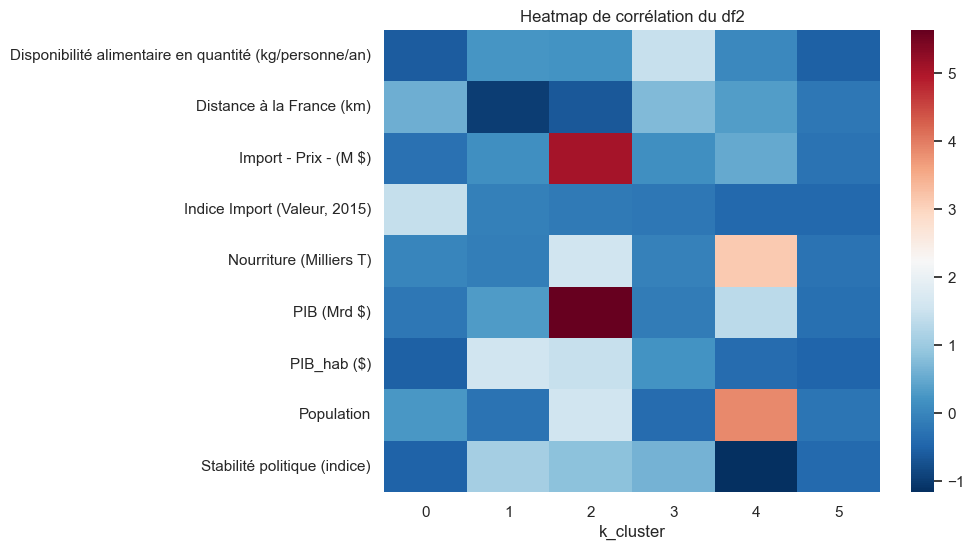

In [49]:
plt.figure(figsize=(8, 6))
sns.heatmap(df2_stand_k_clust.pivot_table(columns="k_cluster", aggfunc='mean', fill_value=0), cmap="RdBu_r")
plt.title("Heatmap de corrélation du df2")
plt.show()

- Cluster 0 : Indice import relativement élevé. Faible disponibilité alimentaire, population et stabilité politique. 
- Cluster 1 : Représente des pays proche de la France, politiquement stable et dont le PIB/hab est plutôt élevé. 
- Cluster 2 : Représente des pays aux indicateurs économiques très élevés. Imports et PIB extrêmement élevé. Nourriture, PIB par habitant, Population et Stabilité politique bien au dessus des moyennes mondiales. 
- Cluster 3 : Disponibilité alimentaire et distance à la france moyennement élevée.
- Cluster 4 : Nourriture et Population élevés ainsi que très faible stabilité politique.  
- Cluster 5 : Toutes les variables sont dans la moyenne ou légèrement en dessous. Cluster peu intéressant.

##### En raisons d'indicateurs économiques élevées ainsi qu'une distance à la France faible qui favoriserons l'exportations de notre production, nous retenons les pays issues des clusters 1 et 2.

<h2 style="font-size:19px;color:blue"> Nuages de points des variables </h2>

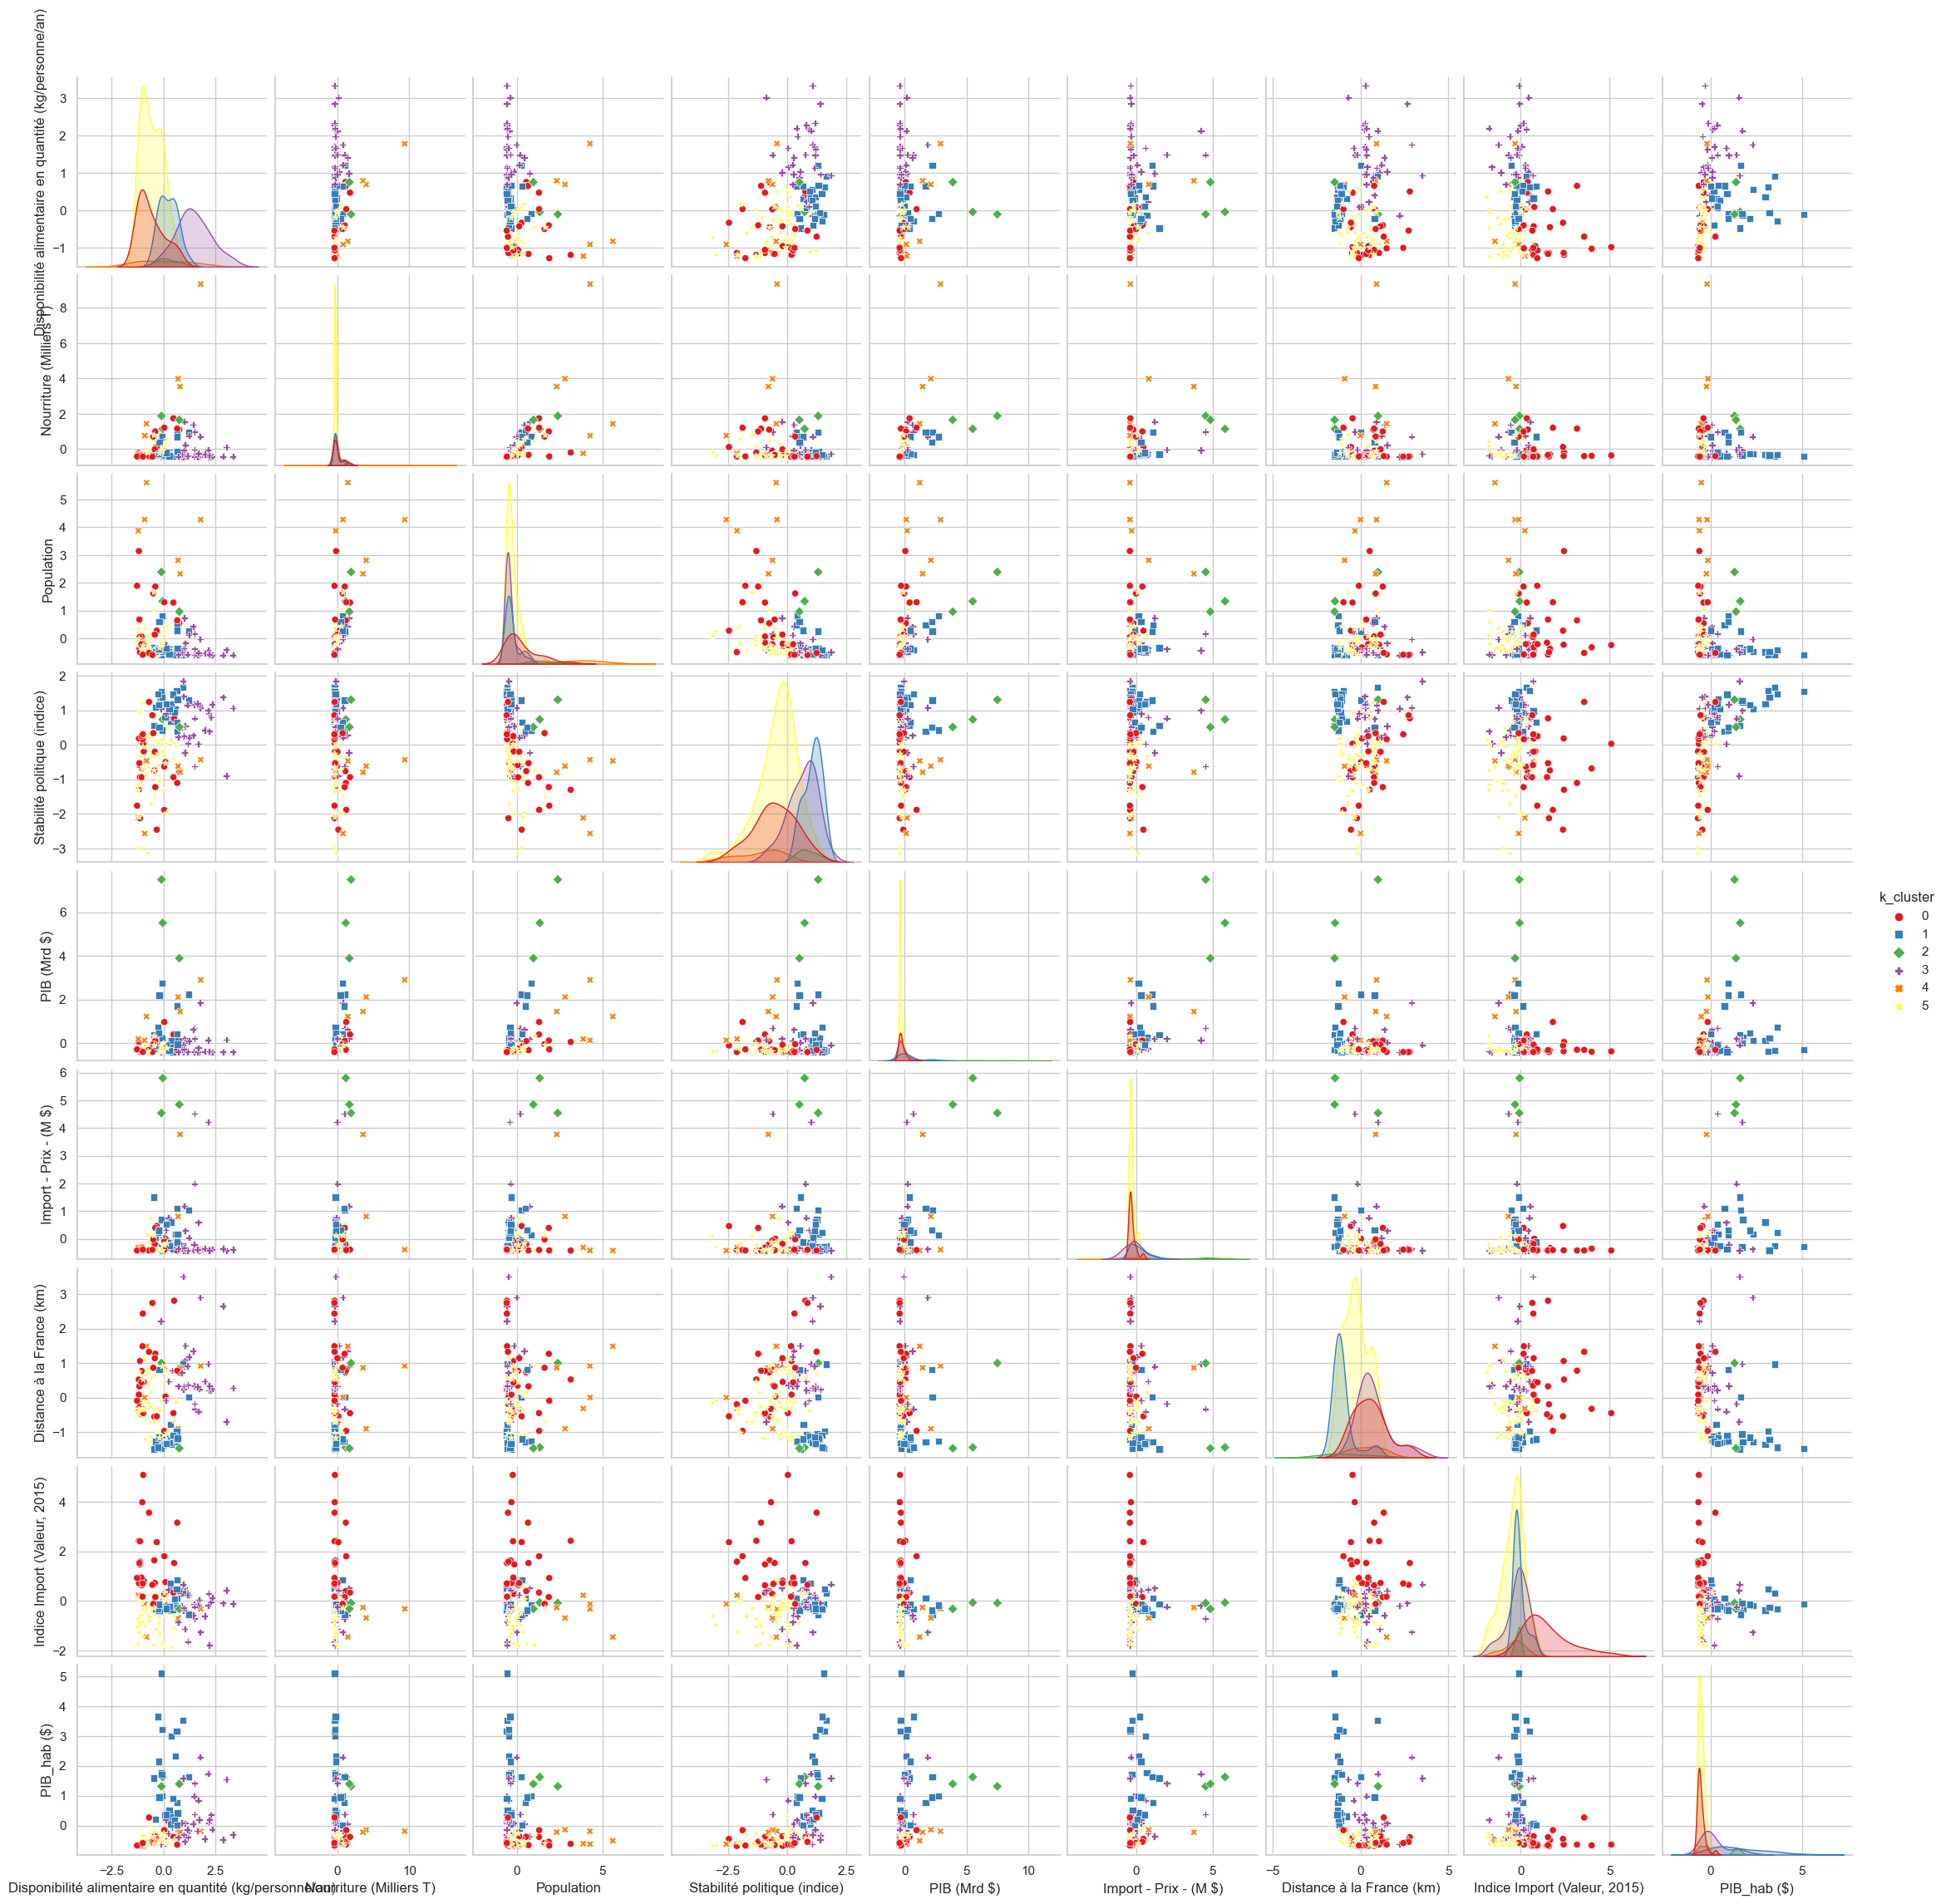

In [50]:
sns.pairplot(df2_stand_k_clust, hue="k_cluster", palette=cluster_palette, markers=["o", "s", "D", "P", "X", "*"])
plt.show()

<h2 style="font-size:19px;color:blue"> Liste des pays des clusters retenus </h2>

In [51]:
df2_k_clust_1_2 = df2_stand_k_clust.loc[df2_stand_k_clust['k_cluster'].isin([1, 2])]
df2_k_clust_1_2

Disponibilité alimentaire en quantité (kg/personne/an)  \
Zone                                                                                                         
Allemagne                                                                                   -0.037148        
Autriche                                                                                    -0.118342        
Belgique                                                                                    -0.473166        
Canada                                                                                       1.212726        
Chine - RAS de Macao                                                                         0.921835        
Chypre                                                                                       0.321511        
Danemark                                                                                     0.570847        
Espagne                                                                                      0.660991        
Estonie                                                                                      0.077290        
Finlande                                                                                    -0.082540        
Hongrie                                                                                      0.333659        
Irlande                                                                                      0.368821        
Islande                                                                                      0.632861        
Italie                                                                                      -0.074868        
Japon                                                                                       -0.099162        
Lituanie                                                                                     0.520341        
Luxembourg                                                                                  -0.110031        
Malte                                                                                        0.455130        
Norvège                                                                                     -0.064000        
Pologne                                                                                      0.655238        
Portugal                                                                                     0.673139        
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                           0.760086        
République de Corée                                                                         -0.214240        
Slovaquie                                                                                   -0.393251        
Slovénie                                                                                     0.278677        
Suisse                                                                                      -0.276894        
Suède                                                                                       -0.220634        
Tchéquie                                                                                     0.122043        

                                                    Nourriture (Milliers T)  \
Zone                                                                          
Allemagne                                                          1.147620   
Autriche                                                          -0.271576   
Belgique                                                          -0.287247   
Canada                                                             0.975240   
Chine - RAS de Macao                                              -0.407717   
Chypre                                                            -0.398902   
Danemark                                                          -0.265700   
Espagne                                 

<h2 style="font-size:19px;color:blue"> Analyse sur plan factoriels </h2>

### Plan factoriel F1/F2

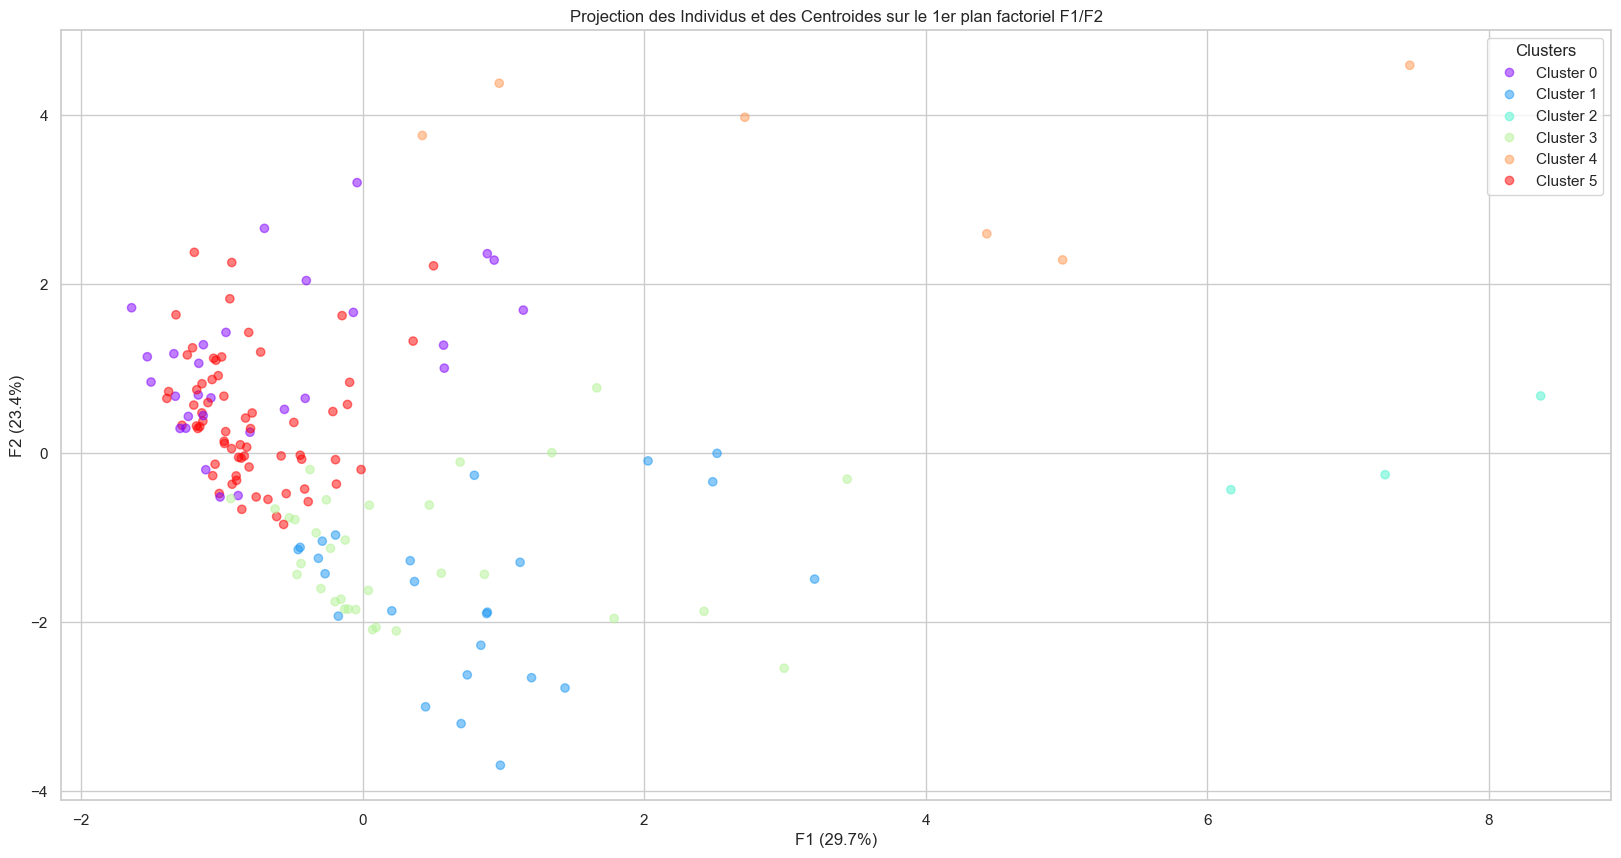

In [52]:
# Coordonnées factorielles
df2_proj = pca.transform(df2_stand_k_clust.iloc[:, :-1])  # Exclure la colonne des clusters ajoutée

plt.figure(figsize=(20, 10))

scatter = plt.scatter(df2_proj[:, 0], df2_proj[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.5)

# Obtenir les numéros de clusters uniques
unique_clusters = np.unique(cluster_labels)

# Créer une légende avec les numéros de clusters et leurs couleurs associées
legend_labels = ['Cluster {}'.format(cluster_num) for cluster_num in unique_clusters]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters")

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title('Projection des Individus et des Centroides sur le 1er plan factoriel F1/F2')
plt.show()

- Sur le premier plan factoriel (F1/F2), on remarque que la distribution des variables est asymétriques, la majorité des valeurs se situent entre -1 et 0 sur l'axe F1.
- L'axe F1, qui est principalement influencé par des variables économiques telles que le PIB, les Importations, la Nourriture... démontre que la majorité des pays possèdent avec des indicateurs économiques inférieurs à la moyenne de ces données centrée réduites
- Ce graphique met une nouvelle fois en évidence le cluster 2 (en vert) et le 4 (orange), qui sont des pays dont les indicateurs économiques sont les plus élevés.

### Plan factoriel F3/F4

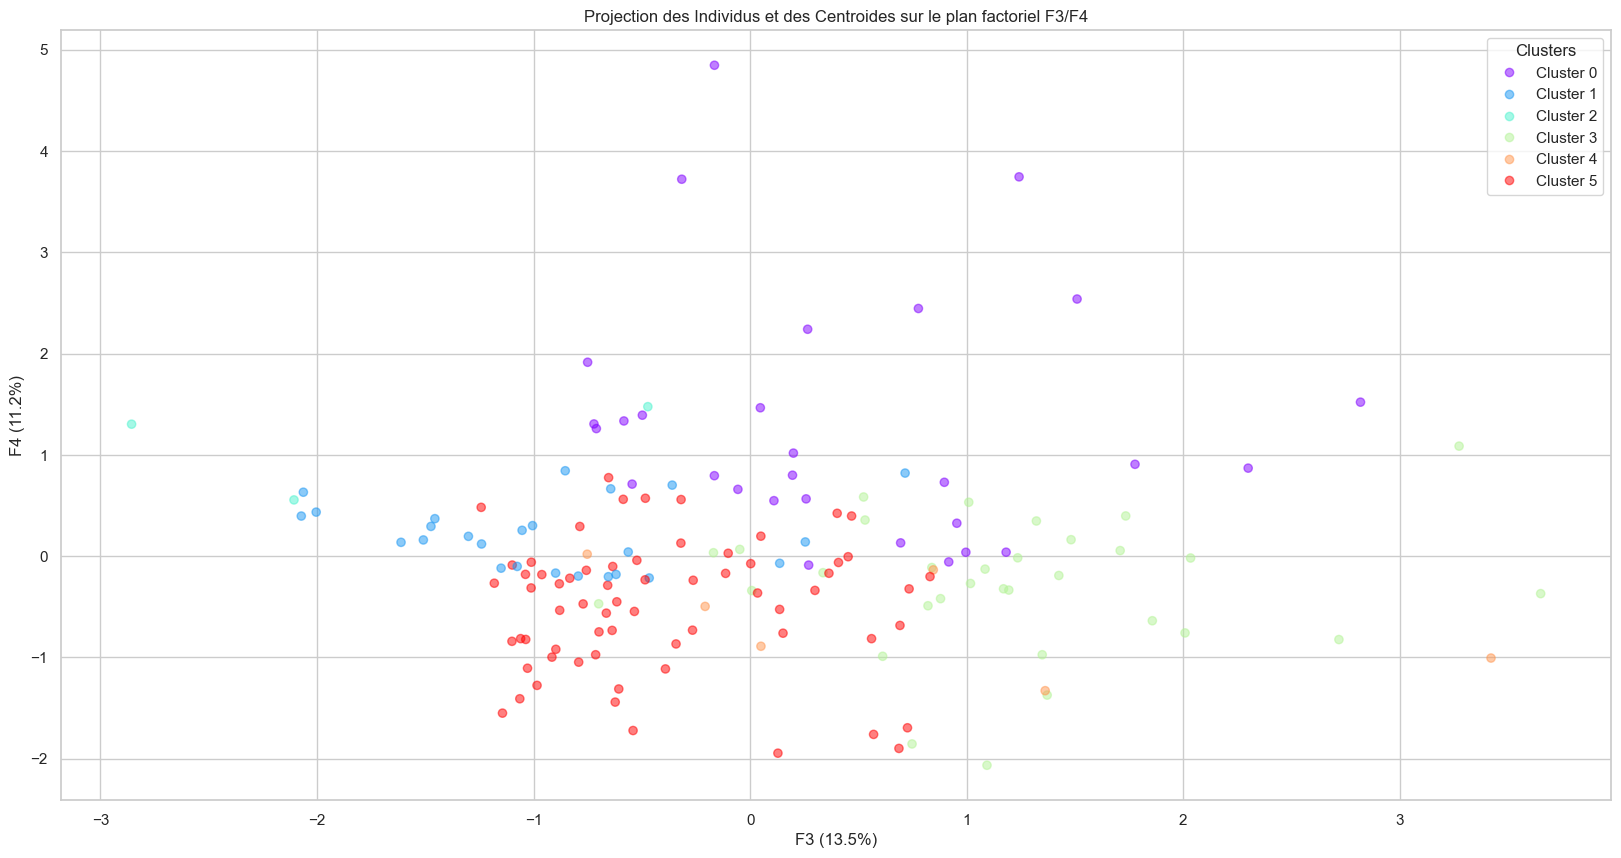

In [53]:
plt.figure(figsize=(20, 10))

scatter = plt.scatter(df2_proj[:, 2], df2_proj[:, 3], c=cluster_labels, cmap='rainbow', alpha=0.5)

# Obtenir les numéros de clusters uniques
unique_clusters = np.unique(cluster_labels)

# Créer une légende avec les numéros de clusters et leurs couleurs associées
legend_labels = ['Cluster {}'.format(cluster_num) for cluster_num in unique_clusters]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters")


plt.xlabel('F{} ({}%)'.format(3, round(100*pca.explained_variance_ratio_[2],1)))
plt.ylabel('F{} ({}%)'.format(4, round(100*pca.explained_variance_ratio_[3],1)))
plt.title('Projection des Individus et des Centroides sur le plan factoriel F3/F4')
plt.show()

- Sur le plan F3/F4, la projection présente une symétrie beaucoup plus marquée. La plupart des points se regroupent entre -1 et 1 sur les axes F3 et F4.

- L'axe F3 présente une corrélation significative avec la distance par rapport à la France. Cela signifie que le positionnement des pays sur l'axe F3 reflète leur éloignement par rapport à la France.

- Le cluster 1 (représenté en bleu) comprendra donc des pays très éloignés géographiquement de la France, ce qui explique pourquoi ils sont positionnés en valeurs élevées sur F3. En revanche, les clusters 0 (violet) et 2 (orange) rassemblent principalement des pays géographiquement proches de la France, ce qui les place en valeurs plus faibles sur F3.

- Concernant l'axe F4, le cluster 3 est très corrélée à l'indice import. Les autres clusters ne montrent pas de différences distinctes dans leur répartition le long de cet axe.

<h2 style="font-size:19px;color:blue"> Analyse des clusters intéressant </h2>

In [ ]:
df2_k_clust_1_2.head()

In [54]:
df2_k_clust_1_2 = df2_k_clust_1_2[df2_k_clust_1_2['Distance à la France (km)'] < -0.5]
df2_k_clust_1_2 = df2_k_clust_1_2.sort_values(by='Import - Prix - (M $)', ascending = False)
df2_k_clust_1_2

Disponibilité alimentaire en quantité (kg/personne/an)  \
Zone                                                                                                         
Allemagne                                                                                   -0.037148        
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                           0.760086        
Belgique                                                                                    -0.473166        
Espagne                                                                                      0.660991        
Autriche                                                                                    -0.118342        
Irlande                                                                                      0.368821        
Tchéquie                                                                                     0.122043        
Suède                                                                                       -0.220634        
Suisse                                                                                      -0.276894        
Portugal                                                                                     0.673139        
Danemark                                                                                     0.570847        
Italie                                                                                      -0.074868        
Slovaquie                                                                                   -0.393251        
Pologne                                                                                      0.655238        
Hongrie                                                                                      0.333659        
Lituanie                                                                                     0.520341        
Slovénie                                                                                     0.278677        
Luxembourg                                                                                  -0.110031        
Finlande                                                                                    -0.082540        
Estonie                                                                                      0.077290        
Chypre                                                                                       0.321511        
Malte                                                                                        0.455130        
Islande                                                                                      0.632861        
Norvège                                                                                     -0.064000        

                                                    Nourriture (Milliers T)  \
Zone                                                                          
Allemagne                                                          1.147620   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                 1.658884   
Belgique                                                          -0.287247   
Espagne                                                            0.960549   
Autriche                                                          -0.271576   
Irlande                                                           -0.307815   
Tchéquie                                                          -0.199098   
Suède                                                             -0.267659   
Suisse                                                            -0.298021   
Portugal                                                          -0.119764   
Danemark                                                          -0.265700   
Italie                                                             0.694143   
Slovaquie                                                         -0.353849   
Pologn

Après suppression des pays trop éloignés de la France et trie sur les imports 

##### Les pays suivants seraient propices à nos exportations car :
- Indicateurs économiques relativement élevées
- Proche de la France
- Propension aux imports de viandes de volailles
- Faible disponibilité alimentaire via leur production

##### En particulier l’Allemagne et le Royaume-Unis en raisons de très fortes importations, d'une distance à la France extrêmement faible et d'une production qui ne comble pas la demande intérieure.

<h2 style="font-size:19px;color:blue"> Analyse des pays issue des deux techniques de clustering </h2>

In [55]:
df2_clust_1_3.head()

Zone  cluster  \
0                                           Allemagne        1   
1                                               Japon        1   
2   Royaume-Uni de Grande-Bretagne et d'Irlande du...        1   
19                                           Autriche        3   
20                                           Belgique        3   

    Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                           -0.037148        
1                                           -0.099162        
2                                            0.760086        
19                                          -0.118342        
20                                          -0.473166        

    Nourriture (Milliers T)  Population  Stabilité politique (indice)  \
0                  1.147620    1.338584                      0.731816   
1                  1.882194    2.389692                      1.302863   
2                  1.658884    0.965178                      0.512183   
19                -0.271576   -0.392119                      1.236973   
20                -0.287247   -0.331181                      0.556109   

    PIB (Mrd $)  Import - Prix - (M $)  Distance à la France (km)  \
0      5.515078               5.809980                  -1.440921   
1      7.508534               4.546082                   1.003263   
2      3.895460               4.854266                  -1.466440   
19     0.252323               0.690594                  -1.284241   
20     0.389782               1.503559                  -1.487646   

    Indice Import (Valeur, 2015)  PIB_hab ($)  
0                      -0.062866     1.626589  
1                      -0.081186     1.313804  
2                      -0.319353     1.394461  
19                     -0.319353     1.765589  
20                     -0.117827     1.593846

In [56]:
df2_k_clust_1_2.head()

Disponibilité alimentaire en quantité (kg/personne/an)  \
Zone                                                                                                         
Allemagne                                                                                   -0.037148        
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                                           0.760086        
Belgique                                                                                    -0.473166        
Espagne                                                                                      0.660991        
Autriche                                                                                    -0.118342        

                                                    Nourriture (Milliers T)  \
Zone                                                                          
Allemagne                                                          1.147620   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                 1.658884   
Belgique                                                          -0.287247   
Espagne                                                            0.960549   
Autriche                                                          -0.271576   

                                                    Population  \
Zone                                                             
Allemagne                                             1.338584   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...    0.965178   
Belgique                                             -0.331181   
Espagne                                               0.494522   
Autriche                                             -0.392119   

                                                    Stabilité politique (indice)  \
Zone                                                                               
Allemagne                                                               0.731816   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                      0.512183   
Belgique                                                                0.556109   
Espagne                                                                 0.391384   
Autriche                                                                1.236973   

                                                    PIB (Mrd $)  \
Zone                                                              
Allemagne                                              5.515078   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...     3.895460   
Belgique                                               0.389782   
Espagne                                                1.692744   
Autriche                                               0.252323   

                                                    Import - Prix - (M $)  \
Zone                                                                        
Allemagne                                                        5.809980   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...               4.854266   
Belgique                                                         1.503559   
Espagne                                                          1.097109   
Autriche                                                         0.690594   

                                                    Distance à la France (km)  \
Zone                                                                            
Allemagne                                                           -1.440921   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                  -1.466440   
Belgique                                                            -1.487646   
Espagne                                                             -1.279105   
Autriche                                                            -1.284241   

                                                    Indice Import (Valeur, 2015)  \
Zone         

In [57]:
# Création de copies
df2_merge_cluster = df2_clust_1_3.copy()
df2_merge_k_cluster = df2_k_clust_1_2.copy()

# Réinitialisation des index sur la colonne "Zone" pour jointure
df2_merge_k_cluster = df2_merge_k_cluster.reset_index()

# Jointure
df2_merge_cluster = df2_merge_cluster[['Zone']]
df2_merge = pd.merge(df2_merge_cluster, df2_merge_k_cluster, on='Zone', how='inner')
df2_merge = df2_merge.drop(columns=['k_cluster'])
df2_merge

Zone  \
0                                           Allemagne   
1   Royaume-Uni de Grande-Bretagne et d'Irlande du...   
2                                            Autriche   
3                                            Belgique   
4                                            Danemark   
5                                            Finlande   
6                                             Irlande   
7                                             Islande   
8                                          Luxembourg   
9                                             Norvège   
10                                             Suisse   
11                                              Suède   

    Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                           -0.037148        
1                                            0.760086        
2                                           -0.118342        
3                                           -0.473166        
4                                            0.570847        
5                                           -0.082540        
6                                            0.368821        
7                                            0.632861        
8                                           -0.110031        
9                                           -0.064000        
10                                          -0.276894        
11                                          -0.220634        

    Nourriture (Milliers T)  Population  Stabilité politique (indice)  \
0                  1.147620    1.338584                      0.731816   
1                  1.658884    0.965178                      0.512183   
2                 -0.271576   -0.392119                      1.236973   
3                 -0.287247   -0.331181                      0.556109   
4                 -0.265700   -0.464490                      1.039303   
5                 -0.327404   -0.469668                      1.269918   
6                 -0.307815   -0.487437                      1.182065   
7                 -0.418491   -0.591011                      1.566423   
8                 -0.417512   -0.584975                      1.544460   
9                 -0.329363   -0.474708                      1.368753   
10                -0.298021   -0.400653                      1.467588   
11                -0.267659   -0.366688                      1.160101   

    PIB (Mrd $)  Import - Prix - (M $)  Distance à la France (km)  \
0      5.515078               5.809980                  -1.440921   
1      3.895460               4.854266                  -1.466440   
2      0.252323               0.690594                  -1.284241   
3      0.389782               1.503559                  -1.487646   
4      0.115448               0.162968                  -1.286224   
5     -0.007493              -0.300073                  -1.053662   
6      0.122291               0.608785                  -1.351872   
7     -0.378729              -0.404430                  -0.968488   
8     -0.312842              -0.276431                  -1.480613   
9      0.221991              -0.414981                  -1.203236   
10     0.714065               0.219344                  -1.441926   
11     0.451281               0.300418                  -1.149827   

    Indice Import (Valeur, 2015)  PIB_hab ($)  
0                      -0.062866     1.626589  
1                      -0.319353     1.394461  
2                      -0.319353     1.765589  
3                      -0.117827     1.593846  
4                      -0.191110     2.321633  
5                      -0.081186     1.717280  
6                      -0.374315     2.992702  
7                       0.486750     3.159169  
8                      -0.117827     5.098173  
9                      -0.246071     3.225658  
10                     -0.319353     3.648963  
11                     -0.136148     2.148096

##### L’Allemagne, le Royaume-Uni, l'Autriche, la Belgique, ou encore le Dannemark figurent dans les clusters intéressant issue des méthodes « Ward » et « K-means »
##### Ces pays seraient très intéressant pour l’export de nos viandes de volailles pour diverses raisons:
- Indicateurs économique élevées 
- Forte propension aux imports de viandes de volailles
- Production insuffisante par rapport à la demande intérieure du pays et sa consommation
- Très faible distance par rapport à la France, réduisant les coûts de transports
- Stabilité politique relativement élevée 